<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
IS_COLAB = False

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [2]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [3]:
import os, sys, re, json
import string
import torch
import numpy as np
import copy
from collections import defaultdict, Counter
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

In [4]:
torch.set_grad_enabled(False)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

## USKG

In [6]:
from transformers import (
    HfArgumentParser,
    set_seed,
    AutoTokenizer
)

# from uskg.models.unified.prefixtuning import Model
from uskg.models.unified import finetune, prefixtuning
from uskg.utils.configue import Configure
from uskg.utils.training_arguments import WrappedSeq2SeqTrainingArguments
from uskg.seq2seq_construction import spider as s2s_spider
from uskg.third_party.spider.preprocess.get_tables import dump_db_json_schema
from uskg.third_party.spider import evaluation as sp_eval
from tqdm.notebook import tqdm

# from nltk.stem.wordnet import WordNetLemmatizer
# import stanza

import matplotlib.pyplot as plt
import sqlite3
from contextlib import contextmanager

from experiments import causal_trace_uskg as ctu

In [7]:
mt_uskg = ctu.ModelAndTokenizer_USKG('t5-large-prefix')

Using tokenizer_uskg: hkunlp/from_all_T5_large_prefix_spider_with_cell_value2
Using tokenizer_fast: t5-large
prefix-tuning sequence length is 10.


In [8]:
list(mt_uskg.task_args.seq2seq)

[('constructor', 'seq2seq_construction.spider'),
 ('schema_serialization_with_db_content', True),
 ('target_with_db_id', False)]

In [9]:
mt_uskg.model.pretrain_model.encoder.embed_tokens is mt_uskg.model.pretrain_model.shared, \
mt_uskg.model.pretrain_model.decoder.embed_tokens is mt_uskg.model.pretrain_model.shared

(True, False)

In [10]:
mt_uskg.model.preseqlen

10

In [11]:
# [k for k,v in mt_uskg.model.named_parameters()]
# [k for k,v in mt_uskg.model.named_modules()]

### Load spider dataset

In [213]:
spider_train_path = '/home/yshao/Projects/SDR-analysis/data/spider/train+ratsql_graph.json'
spider_dev_path = '/home/yshao/Projects/SDR-analysis/data/spider/dev+ratsql_graph.json'
spider_db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [214]:
raw_spider_dev = ctu.load_raw_dataset(
    data_filepath = spider_dev_path,
    db_path=spider_db_dir,
#     schema_cache=SCHEMA_CACHE
)
len(raw_spider_dev)

1034

In [215]:
raw_spider_dev[0].keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph'])

In [216]:
mt_uskg.task_args.dataset.use_cache

True

In [217]:
processed_spider_dev = s2s_spider.DevDataset(
    args=mt_uskg.task_args,
    raw_datasets=raw_spider_dev,
    cache_root='../cache')

In [218]:
_id = 130
processed_spider_dev[_id]['text_in'], \
processed_spider_dev[_id]['struct_in'], \
processed_spider_dev[_id]['seq_out']

('What are the names of all European countries with at least 3 manufacturers?',
 '| car_1 | continents : contid , continent ( europe ) | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.countryname from countries as t1 join continents as t2 on t1.continent = t2.contid join car_makers as t3 on t1.countryid = t3.country where t2.continent = 'europe' group by t1.countryname having count(*) >= 3;")

In [219]:
_enc_sentence = f"{processed_spider_dev[_id]['text_in']}; structed knowledge: {processed_spider_dev[_id]['struct_in']}"
_toks = mt_uskg.tokenizer.tokenize(_enc_sentence)
len(_toks)

142

In [19]:
# # _occ_punct = set()

# for _id in range(len(processed_spider_dev)):
#     ex = processed_spider_dev[_id]
# #     _occ_punct.update(set(string.punctuation) & set(ex['seq_out']))
#     if '_(' in ex['struct_in']:
#         print(_id, ex['question'])
#         print(ex['struct_in'])
#         print(ex['seq_out'])
#         print()

In [20]:
# ## Train set

# raw_spider_train = ctu.load_raw_dataset(
#     data_filepath = spider_train_path,
#     db_path=spider_db_dir,
# )
# processed_spider_train = s2s_spider.TrainDataset(
#     args=mt_uskg.task_args,
#     raw_datasets=raw_spider_train,
#     cache_root='../cache')
# len(processed_spider_train)

In [21]:
# processed_spider_train[5441]

### Helpers
- merged in create_analysis_sample_dicts()

#### Evaluator

In [22]:
table_path = '/home/yshao/Projects/language/language/xsp/data/spider/tables.json'
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [23]:
kmaps = sp_eval.build_foreign_key_map_from_json(table_path)
evaluator = sp_eval.Evaluator(db_dir=db_dir, kmaps=kmaps, etype='all')

In [24]:
ctu.evaluate_hardness.evaluator = evaluator

In [25]:
# test
_sql_str = 'select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id = t2.people_id order by t2.earnings asc limit 1'
db_name = 'poker_player'
schema = evaluator.schemas[db_name]
_sql = sp_eval.get_sql(schema, _sql_str)
sp_eval.count_component1(_sql), sp_eval.count_component2(_sql), sp_eval.count_others(_sql), \
evaluator.eval_hardness(_sql)

(3, 0, 0, 'hard')

#### Utils

In [348]:
def reverse_2D_dict(d):
    out_d = defaultdict(lambda: defaultdict(np.nan))
    for k1, d1 in d.items():
        for k2, v in d1.items():
            out_d[k2][k1] = v
    return out_d

def format_print_1D_dict(d, sort_by=None, reverse=False, head_col_w=10, col_w=6):
    # sort: None, 'key' or 'value'
    
    item_l = list(d.items())
    if sort_by == 'key':
        item_l.sort(reverse=reverse)
    elif sort_by == 'value':
        item_l.sort(key=lambda x: (x[1], x[0]), reverse=reverse)
    
    decm_w = col_w - 2
    
    for k, v in item_l:
        print(f'{k:<{head_col_w}s}{v:.{decm_w}f}')

def format_print_2D_dict(d, 
                         all_k1=None, 
                         all_k2=None, 
                         sort_k1_kwargs=None, 
                         sort_k2_kwargs=None, 
                         head_col_w=12, 
                         col_w=6,
                         decm_w=4):
    if all_k1 is None:
        all_k1 = list(d.keys())
        if sort_k1_kwargs is not None:
            all_k1.sort(**sort_k1_kwargs)
    
    if all_k2 is None:
        for k1, d1 in d.items():
            d1_keys = list(d1.keys())
            if all_k2 is None:
                all_k2 = d1_keys
            else:
                if set(d1_keys) != set(all_k2):
                    print('Warning:\n', d1_keys, '\n', all_k2)
            # all_k2.update(list(d1.keys()))
        if sort_k2_kwargs is not None:
            all_k2.sort(**sort_k2_kwargs)
    
    print_str = '\t'.join(['X' * head_col_w] + [f'{k2:<{col_w}s}' for k2 in all_k2]) + '\n'
    
    for k1 in all_k1:
        d1 = d[k1]
        print_str += f'{k1:<{head_col_w}s}'
        for k2 in all_k2:
            v = d1[k2]
            print_str += f'\t{v:<{col_w}.{decm_w}f}'
        print_str += '\n'
    
    print(print_str)

## USKG error analysis

In [141]:
# adapted from play_pred()

def pred_sql(mt, ex, padding="max_length"):
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    txt = f"{text_in}; structed knowledge: {struct_in}"
    
    tokenized_txt = mt.tokenizer_uskg([txt], max_length=1024, padding=padding, truncation=True)
    
    device = mt.model.device
    pred = mt.tokenizer_uskg.batch_decode(
      mt.model.generate(
        torch.tensor(tokenized_txt.data['input_ids'], dtype=int, device=device),
        torch.tensor(tokenized_txt.data['attention_mask'], dtype=int, device=device),
        num_beams=1, 
        max_length=256
        ), 
      skip_special_tokens=True 
    )
    return pred[0]


In [142]:
# adapted from evaluator.evaluate_one()

def evaluate_sql(evaluator, db_name, gold, predicted):
    schema = evaluator.schemas[db_name]
    g_sql = sp_eval.get_sql(schema, gold)
    hardness = evaluator.eval_hardness(g_sql)
    # self.scores[hardness]["count"] += 1
    # self.scores["all"]["count"] += 1

    parse_error = False
    try:
        p_sql = sp_eval.get_sql(schema, predicted)
    except:
        # If p_sql is not valid, then we will use an empty sql to evaluate with the correct sql
        p_sql = {
            "except": None,
            "from": {"conds": [], "table_units": []},
            "groupBy": [],
            "having": [],
            "intersect": None,
            "limit": None,
            "orderBy": [],
            "select": [False, []],
            "union": None,
            "where": [],
        }

        # TODO fix
        parse_error = True

    # rebuild sql for value evaluation
    kmap = evaluator.kmaps[db_name]
    g_valid_col_units = sp_eval.build_valid_col_units(g_sql["from"]["table_units"], schema)
    g_sql = sp_eval.rebuild_sql_val(g_sql)
    g_sql = sp_eval.rebuild_sql_col(g_valid_col_units, g_sql, kmap)
    p_valid_col_units = sp_eval.build_valid_col_units(p_sql["from"]["table_units"], schema)
    p_sql = sp_eval.rebuild_sql_val(p_sql)
    p_sql = sp_eval.rebuild_sql_col(p_valid_col_units, p_sql, kmap)
    
    exec_score = None
    partial_scores = None
    exact_score = None
    if evaluator.etype in ["all", "exec"]:
        try:
            exec_score = sp_eval.eval_exec_match(
                evaluator.db_paths[db_name], predicted, gold, p_sql, g_sql
            )
            exec_score = int(exec_score)
        except:
            exec_score = 0
    if evaluator.etype in ["all", "match"]:
        partial_scores = evaluator.eval_partial_match(p_sql, g_sql)
        exact_score = evaluator.eval_exact_match(p_sql, g_sql, partial_scores)
        # update_scores_match(self.scores, exact_score, hardness, partial_scores, PARTIAL_TYPES)

    return {
        "predicted": predicted,
        "gold": gold,
        "predicted_parse_error": parse_error,
        "hardness": hardness,
        "exact": exact_score,
        "partial": partial_scores,
        "exec": exec_score,
    }

In [143]:
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

def execute_sql(db, sql_str):
    db_path = os.path.join(db_dir, db, f'{db}.sqlite')
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute(sql_str)
        res = cursor.fetchall()
    except:
        res = 'ERROR'
    conn.close()
    return res

In [29]:
ex = processed_spider_dev[123]
ex.keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out'])

In [30]:
pred = pred_sql(mt_uskg, ex)
ex['db_id'], ex['text_in'], ex['seq_out'], pred

('car_1',
 'What are the countries having at least one car maker? List name and id.',
 'select t1.countryname, t1.countryid from countries as t1 join car_makers as t2 on t1.countryid = t2.country group by t1.countryid having count(*) >= 1;',
 'select t1.countryname, t1.id from countries as t1 join car_makers as t2 on t1.countryid = t2.country group by t1.countryname having count(*) >= 1')

In [31]:
pred = pred_sql(mt_uskg, ex, padding=False)
ex['db_id'], ex['text_in'], ex['seq_out'], pred

('car_1',
 'What are the countries having at least one car maker? List name and id.',
 'select t1.countryname, t1.countryid from countries as t1 join car_makers as t2 on t1.countryid = t2.country group by t1.countryid having count(*) >= 1;',
 'select t1.countryname, t1.id from countries as t1 join car_makers as t2 on t1.countryid = t2.country group by t1.countryname having count(*) >= 1')

In [ ]:
# temp

In [28]:
text_in = ex['text_in']
struct_in = ex['struct_in']
txt = f"{text_in}; structed knowledge: {struct_in}"
txt_toks = mt_uskg.tokenizer_uskg.tokenize(txt)
len(txt_toks)

126

In [ ]:
txt_toks

In [30]:
exec_res = execute_sql(ex['db_id'], ex['seq_out'])
ex['seq_out'], exec_res

("select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );",
 [(7,)])

In [31]:
exec_res = execute_sql(ex['db_id'], pred)
pred, exec_res

('select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage > 225 )',
 [(3,)])

In [32]:
chatgpt_pred = """
SELECT COUNT(DISTINCT battle.id) AS num_battles
FROM battle
LEFT JOIN ship ON battle.id = ship.lost_in_battle
WHERE (ship.tonnage != '225' OR ship.tonnage IS NULL)
"""

execute_sql(ex['db_id'], chatgpt_pred)

[(8,)]

In [ ]:
# eval_res = evaluate_sql(evaluator, db_name=spider_ex['db_id'], gold=spider_ex['seq_out'], predicted=pred)
# eval_res

### Eval all

In [67]:
all_preds = []
eval_sql_results = []

for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
    pred = pred_sql(mt_uskg, ex, padding=False)
    eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)
    
    all_preds.append(pred)
    eval_sql_results.append(eval_res)

  0%|          | 0/1034 [00:00<?, ?it/s]

In [68]:
# no padding; identical!
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.6692456479690522, 0.6808510638297872)

In [69]:
res_dir = '/home/yshao/Projects/rome/results/clean_predictions'
os.makedirs(res_dir, exist_ok=True)

pred_path = os.path.join(res_dir, 'predictions.txt')
eval_path = os.path.join(res_dir, 'evals.jsonl')

with open(pred_path, 'w') as f:
    for p in all_preds:
        f.write(p + '\n')

with open(eval_path, 'w') as f:
    for e in eval_sql_results:
        f.write(json.dumps(e, indent=None) + '\n')

In [412]:
# padding to 1024 
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.6692456479690522, 0.6808510638297872)

### Actual error cases

In [ ]:
for i, d in enumerate(eval_sql_results):
    if d['exact'] and d['exec']:
        continue
    err_msg = ('A' if not d['exact'] else '') + ('X' if not d['exec'] else '')
    ex = processed_spider_dev[i]
    print(f'ID = {i}: {err_msg}  ({ex["db_id"]}) {ex["text_in"]}')
    print(f'Pred: {d["predicted"]}')
    print(f'Gold: {d["gold"]}')
    print()

In [ ]:
evaluator.schemas['dog_kennels'].schema

In [414]:
# acc by db_id 
eval_sql_results_by_db_id = defaultdict(list)

for i, d in enumerate(eval_sql_results):
    d['ex_id'] = i
    ex = processed_spider_dev[i]
    db_id = ex['db_id']
    eval_sql_results_by_db_id[db_id].append(d)

len(eval_sql_results_by_db_id)

20

In [415]:
for db_id, results in eval_sql_results_by_db_id.items():
    _avg_exact = np.mean([d['exact'] for d in results])
    _avg_exec = np.mean([d['exec'] for d in results])
    print(f'{db_id}\t{_avg_exact:.4f}\t{_avg_exec:.4f}')

concert_singer	0.8889	0.8889
pets_1	0.5714	0.7381
car_1	0.3478	0.3913
flight_2	0.7000	0.7500
employee_hire_evaluation	0.9474	0.9737
cre_Doc_Template_Mgt	0.8333	0.9048
course_teach	0.8667	0.9333
museum_visit	0.7222	0.8333
wta_1	0.6774	0.6129
battle_death	0.5000	0.5000
student_transcripts_tracking	0.6667	0.6795
tvshow	0.7258	0.6613
poker_player	0.8750	0.8750
voter_1	0.6000	0.6667
world_1	0.5083	0.4833
orchestra	0.8000	0.8750
network_1	0.6250	0.4643
dog_kennels	0.5854	0.5976
singer	0.8667	0.8667
real_estate_properties	0.5000	0.5000


## Full SQL prediction with edit

### Encoder attention (exp A1.0)

In [32]:
def build_enc_self_attention_mask_for_section_pair(
    ex,
    q_sect,
    k_sect,
    seq_len=None,
    mt=None,
    prefix_len=10):
    
    """
    For attention-related experiments: build encoder self-attention masks for a section pair

    Args:
    a_ex (Dict)
    q_sect (str)
    k_sect (str)
    seq_len (int): sequence length
    prefix_len (int): prefix length
    
    """

    enc_sentence = ex['enc_sentence']

    text_range = ex['text_range']
    struct_range = ex['struct_range']
    text_st, text_ed = text_range
    struct_st, struct_ed = struct_range
    # text_tok_indices = list(range(*text_range))
    # struct_tok_indices = list(range(*struct_range))
    
    token_ranges_dict = ex['struct_node_ranges_dict']

    if seq_len is None:
        # need to tokenize and decide seq_len
        assert mt is not None
        _tok_ids = mt.tokenizer.encode(enc_sentence, add_special_tokens=True)
        seq_len = len(_tok_ids)

    # seq_len should include EOS, while struct shouldn't 
    assert seq_len == struct_ed + 1, (seq_len, struct_ed)
    
    ## Config for each section
    ## 'is_range': whether the section is a single range 
    ## 'pos': if is_range, a tuple for the range; otherwise, a list of indices 
    ## Note: not including "self" and "context" sect for now; they don't fit into this config format 
    section_configs = {
        'text': {
            'is_range': True,
            'q_pos': (text_st, text_ed),
            'k_pos': (text_st + prefix_len, text_ed + prefix_len),
        },
        'struct': {
            'is_range': True,
            'q_pos': (struct_st, struct_ed),
            'k_pos': (struct_st + prefix_len, struct_ed + prefix_len),
        },
        'prefix': {
            'is_range': True,
            'q_pos': None,  # prefix does not have q 
            'k_pos': (0, prefix_len),
        },
        'eos': {
            'is_range': True,
            'q_pos': (seq_len - 1, seq_len),
            'k_pos': (seq_len + prefix_len - 1, seq_len + prefix_len),
        },
        'all': {
            'is_range': True,
            'q_pos': (0, seq_len),
            'k_pos': (0, seq_len + prefix_len),
        },
    }

    # mix_mask: (batch, head, src_len, tgt_len)
    mix_mask = torch.zeros(1, 1, seq_len, seq_len + prefix_len).bool()
    
    if q_sect == 'self':
        raise NotImplementedError
    else:
        q_config = section_configs[q_sect]
        k_config = section_configs[k_sect]
        
        # For now, all config is range 
        assert q_config['is_range'] and k_config['is_range']
        
        q_st, q_ed = q_config['q_pos']
        k_st, k_ed = k_config['k_pos']
        
        mix_mask[:, :, q_st : q_ed, k_st : k_ed] = True
    
    return mix_mask


In [114]:
@contextmanager
def add_enc_attention_edit(mt, ex, mix_layers, section_pairs, attn_corrupt_type='weights'):
    """ 
    Args:
        mix_layers: List[int], the layers to edit
        section_pairs: List[Tuple(str, str)]: corrupting attention from which to which
            sections: "text", "struct", "prefix", "eos"; "self", "context"
            (notice that "self" is per-node; "context->context" is invalid here)
        attn_corrupt_type: (same as trace exp) weights / logits 
    """
    
    ## Code to be executed when entering the context
    
    ex = copy.deepcopy(ex)
    
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
    enc_tokenized = mt.tokenizer(enc_sentence)
    ex['enc_sentence'] = enc_sentence
    ex['enc_tokenized'] = enc_tokenized
    
    parsed_struct_in = ctu.parse_struct_in(struct_in)
    
    token_ranges_dict = ctu.find_struct_name_ranges(mt.tokenizer, ex)
    text_range = ex['text_range']
    struct_range = ex['struct_range']
    # token_ranges_dict = ex['struct_node_ranges_dict']

    all_mix_masks = [build_enc_self_attention_mask_for_section_pair(
            ex,
            q_sect,
            k_sect,
            mt=mt) for q_sect, k_sect in section_pairs]
    
    mix_mask = torch.logical_or(*all_mix_masks) if len(all_mix_masks) > 1 else all_mix_masks[0]
    
    def _attn_w_fn(attn):
        _mix_mask = mix_mask.to(device=attn.device)
        _zero = torch.tensor(0, dtype=attn.dtype, device=attn.device)
        attn = torch.where(_mix_mask, _zero, attn)     # no need to keep batch_idx=0 clean here
        return attn

    def _attn_lg_fn(attn):
        _mix_mask = mix_mask.to(device=attn.device)
        _neg = torch.tensor(-1e9, dtype=attn.dtype, device=attn.device)
        attn = torch.where(_mix_mask, _neg, attn)
        return attn

#     def p_hook_fn(m, inp):
#         if attn_corrupt_type == 'weights':
#             m.ext_attention_weights_fn = _attn_w_fn
#         elif attn_corrupt_type == 'logits':
#             m.ext_attention_logits_fn = _attn_lg_fn
#         else:
#             raise ValueError(attn_corrupt_type)

#     def f_hook_fn(m, inp, outp):
#         m.ext_attention_weights_fn = None
#         m.ext_attention_logits_fn = None

#     all_hooks = []

    edit_module_list = [nethook.get_module(mt.model, layer) for layer in mix_layers]
    for m in edit_module_list:
        if attn_corrupt_type == 'weights':
            m.ext_attention_weights_fn = _attn_w_fn
        elif attn_corrupt_type == 'logits':
            m.ext_attention_logits_fn = _attn_lg_fn

    try:
        ## You can yield any object that will be bound to the variable after 'as' in 'with' statement
        yield
        
    finally:
        ## Code to be executed when exiting the context
        for m in edit_module_list:
            m.ext_attention_weights_fn = None
            m.ext_attention_logits_fn = None
        
    

In [115]:
a1_0_result_dir = '/home/yshao/Projects/rome/results/exp_A1_0_enc_attention_removal_eval'
os.makedirs(a1_0_result_dir, exist_ok=True)

#### Running for all configs

In [151]:
## Current exp: A1.0.1 (attn_corrupt_type=logits)

# layer_k -> layer range 
layer_configs = {
#     'low': range(12),
    'mid': range(6, 18),
    'high': range(12, 24),
#     'all': range(24),
}

# sect_k -> section pairs
sect_configs = {
    's->t': [('struct', 'text')],
    't->s': [('text', 'struct')],
    't<->s': [('struct', 'text'), ('text', 'struct')],
}

In [152]:
for layer_k, layer_range in layer_configs.items():
    for sect_k, section_pairs in sect_configs.items():
        mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in layer_range]

        all_preds = []
        eval_sql_results = []

        for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
            with add_enc_attention_edit(mt=mt_uskg,
                                    ex=ex,
                                    mix_layers=mix_layers,
                                    section_pairs=section_pairs,
                                    attn_corrupt_type='logits'):
                pred = pred_sql(mt_uskg, ex, padding=False)

            eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)

            all_preds.append(pred)
            eval_sql_results.append(eval_res)
        
        avg_exact = np.mean([d['exact'] for d in eval_sql_results])
        avg_exec = np.mean([d['exec'] for d in eval_sql_results])
        print(f'Layer = {layer_k}, Sect = {sect_k} : Exact = {avg_exact:.4f}, Exec = {avg_exec:.4f}')
        
        pred_path = os.path.join(a1_0_result_dir, f'exp=A1.0.1_dev_predictions-layer={layer_k}-sect={sect_k}.txt')
        eval_path = os.path.join(a1_0_result_dir, f'exp=A1.0.1_dev_evals-layer={layer_k}-sect={sect_k}.jsonl')

        with open(pred_path, 'w') as f:
            for p in all_preds:
                f.write(p + '\n')

        with open(eval_path, 'w') as f:
            for e in eval_sql_results:
                f.write(json.dumps(e, indent=None) + '\n')

  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = mid, Sect = s->t : Exact = 0.5019, Exec = 0.5184


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = mid, Sect = t->s : Exact = 0.6451, Exec = 0.6586


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = mid, Sect = t<->s : Exact = 0.4294, Exec = 0.4468


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = high, Sect = s->t : Exact = 0.4072, Exec = 0.4362


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = high, Sect = t->s : Exact = 0.6151, Exec = 0.6412


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = high, Sect = t<->s : Exact = 0.3250, Exec = 0.3559


### Decoder cross attention (exp A1.1)

In [88]:
def build_dec_cross_attention_mask_for_section(
    ex,
    k_sect,
    seq_len=None,
    mt=None,
    prefix_len=10):
    
    """
    For attention-related experiments: build decoder cross-attention mask for an input section, block all-step X-att to this section 
    The q dimension is set to 1; in edit fn, it will be broadcasted to the correct size

    Args:
    a_ex (Dict)
    k_sect (str)
    seq_len (int): sequence length
    prefix_len (int): prefix length
    
    """

    enc_sentence = ex['enc_sentence']

    text_range = ex['text_range']
    struct_range = ex['struct_range']
    text_st, text_ed = text_range
    struct_st, struct_ed = struct_range
    # text_tok_indices = list(range(*text_range))
    # struct_tok_indices = list(range(*struct_range))
    
    token_ranges_dict = ex['struct_node_ranges_dict']

    if seq_len is None:
        # need to tokenize and decide seq_len
        assert mt is not None
        _tok_ids = mt.tokenizer.encode(enc_sentence, add_special_tokens=True)
        seq_len = len(_tok_ids)

    # seq_len should include EOS, while struct shouldn't 
    assert seq_len == struct_ed + 1, (seq_len, struct_ed)
    
    ## Config for each section
    ## 'is_range': whether the section is a single range 
    ## 'pos': if is_range, a tuple for the range; otherwise, a list of indices 
    ## Note: not including "self" and "context" sect for now; they don't fit into this config format 
    section_configs = {
        'text': {
            'is_range': True,
            'k_pos': (text_st + prefix_len, text_ed + prefix_len),
        },
        'struct': {
            'is_range': True,
            'k_pos': (struct_st + prefix_len, struct_ed + prefix_len),
        },
        'prefix': {
            'is_range': True,
            'k_pos': (0, prefix_len),
        },
        'others': {
            'is_range': False,
            'k_pos': list(range(text_ed + prefix_len, struct_st + prefix_len)) + list(range(seq_len + prefix_len - 1, seq_len + prefix_len)),
        },
        'all': {
            'is_range': True,
            'k_pos': (0, seq_len + prefix_len),
        },
    }

    # mix_mask: (batch, head, src_len, tgt_len)
    mix_mask = torch.zeros(1, 1, 1, seq_len + prefix_len).bool()
    
    k_config = section_configs[k_sect]

    if k_config['is_range']:
        k_st, k_ed = k_config['k_pos']
        mix_mask[:, :, :, k_st : k_ed] = True
    else:
        k_toks = k_config['k_pos']
        mix_mask[:, :, :, k_toks] = True
    
    return mix_mask


In [125]:
@contextmanager
def add_dec_cross_attention_edit(mt, ex, mix_layers, sections, attn_corrupt_type='weights'):
    """ 
    Args:
        mix_layers: List[int], the layers to edit
        section: List[str]: corrupting attention from decoder to which sections
            sections: "text", "struct", "prefix", "others"; "self", "context" (not implemented)
            (notice that "self" is per-node; "context->context" is invalid here)
        attn_corrupt_type: (same as trace exp) weights / logits 
    """
    
    ## Code to be executed when entering the context
    
    ex = copy.deepcopy(ex)
    
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
    enc_tokenized = mt.tokenizer(enc_sentence)
    ex['enc_sentence'] = enc_sentence
    ex['enc_tokenized'] = enc_tokenized
    
    parsed_struct_in = ctu.parse_struct_in(struct_in)
    
    token_ranges_dict = ctu.find_struct_name_ranges(mt.tokenizer, ex)
    text_range = ex['text_range']
    struct_range = ex['struct_range']
    # token_ranges_dict = ex['struct_node_ranges_dict']

    all_mix_masks = [build_dec_cross_attention_mask_for_section(
            ex,
            k_sect,
            mt=mt) for k_sect in sections]
    
    mix_mask = torch.logical_or(*all_mix_masks) if len(all_mix_masks) > 1 else all_mix_masks[0]
    # print(mix_mask)
    
    def _attn_w_fn(attn):
        _mix_mask = mix_mask.to(device=attn.device)
        _zero = torch.tensor(0, dtype=attn.dtype, device=attn.device)
        attn = torch.where(_mix_mask, _zero, attn)     # no need to keep batch_idx=0 clean here
        return attn

    def _attn_lg_fn(attn):
        _mix_mask = mix_mask.to(device=attn.device)
        _neg = torch.tensor(-1e9, dtype=attn.dtype, device=attn.device)
        attn = torch.where(_mix_mask, _neg, attn)
        return attn

#     def p_hook_fn(m, inp):
#         if attn_corrupt_type == 'weights':
#             m.ext_attention_weights_fn = _attn_w_fn
#         elif attn_corrupt_type == 'logits':
#             m.ext_attention_logits_fn = _attn_lg_fn
#         else:
#             raise ValueError(attn_corrupt_type)

#     def f_hook_fn(m, inp, outp):
#         m.ext_attention_weights_fn = None
#         m.ext_attention_logits_fn = None

#     all_hooks = []

    edit_module_list = [nethook.get_module(mt.model, layer) for layer in mix_layers]
    for m in edit_module_list:
        if attn_corrupt_type == 'weights':
            m.ext_attention_weights_fn = _attn_w_fn
        elif attn_corrupt_type == 'logits':
            m.ext_attention_logits_fn = _attn_lg_fn

    try:
        ## You can yield any object that will be bound to the variable after 'as' in 'with' statement
        yield
        
    finally:
        ## Code to be executed when exiting the context
        for m in edit_module_list:
            m.ext_attention_weights_fn = None
            m.ext_attention_logits_fn = None
        
    

In [93]:
a1_1_result_dir = '/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval'
os.makedirs(a1_1_result_dir, exist_ok=True)

#### Running for all configs

In [147]:
## Current exp: A1.1.0 (attn_corrupt_type=weights); A1.1.1 (attn_corrupt_type=logits);

# layer_k -> layer range 
layer_configs = {
    'low': range(12),
    'mid': range(6, 18),
    'high': range(12, 24),
    'all': range(24),
}

# sect_k -> section pairs
sect_configs = {
    'text': ['text'],
    'struct': ['struct'],
}

In [146]:
for layer_k, layer_range in layer_configs.items():
    for sect_k, sections in sect_configs.items():
        mix_layers = [ctu.layername_uskg(mt_uskg.model, 'decoder', l, 'cross_attn') for l in layer_range]

        all_preds = []
        eval_sql_results = []

        for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
            with add_dec_cross_attention_edit(mt=mt_uskg,
                                            ex=ex,
                                            mix_layers=mix_layers,
                                            sections=sections,
                                            attn_corrupt_type='weights'):
                pred = pred_sql(mt_uskg, ex, padding=False)

            eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)

            all_preds.append(pred)
            eval_sql_results.append(eval_res)
        
        avg_exact = np.mean([d['exact'] for d in eval_sql_results])
        avg_exec = np.mean([d['exec'] for d in eval_sql_results])
        print(f'Layer = {layer_k}, Sect = {sect_k} : Exact = {avg_exact:.4f}, Exec = {avg_exec:.4f}')
        
        pred_path = os.path.join(a1_1_result_dir, f'exp=A1.1.0_dev_predictions-layer={layer_k}-sect={sect_k}.txt')
        eval_path = os.path.join(a1_1_result_dir, f'exp=A1.1.0_dev_evals-layer={layer_k}-sect={sect_k}.jsonl')

        with open(pred_path, 'w') as f:
            for p in all_preds:
                f.write(p + '\n')

        with open(eval_path, 'w') as f:
            for e in eval_sql_results:
                f.write(json.dumps(e, indent=None) + '\n')

  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = all, Sect = text : Exact = 0.0996, Exec = 0.1015


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = all, Sect = struct : Exact = 0.0010, Exec = 0.0010


In [148]:
for layer_k, layer_range in layer_configs.items():
    for sect_k, sections in sect_configs.items():
        mix_layers = [ctu.layername_uskg(mt_uskg.model, 'decoder', l, 'cross_attn') for l in layer_range]

        all_preds = []
        eval_sql_results = []

        for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
            with add_dec_cross_attention_edit(mt=mt_uskg,
                                            ex=ex,
                                            mix_layers=mix_layers,
                                            sections=sections,
                                            attn_corrupt_type='logits'):
                pred = pred_sql(mt_uskg, ex, padding=False)

            eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)

            all_preds.append(pred)
            eval_sql_results.append(eval_res)
        
        avg_exact = np.mean([d['exact'] for d in eval_sql_results])
        avg_exec = np.mean([d['exec'] for d in eval_sql_results])
        print(f'Layer = {layer_k}, Sect = {sect_k} : Exact = {avg_exact:.4f}, Exec = {avg_exec:.4f}')
        
        pred_path = os.path.join(a1_1_result_dir, f'exp=A1.1.1_dev_predictions-layer={layer_k}-sect={sect_k}.txt')
        eval_path = os.path.join(a1_1_result_dir, f'exp=A1.1.1_dev_evals-layer={layer_k}-sect={sect_k}.jsonl')

        with open(pred_path, 'w') as f:
            for p in all_preds:
                f.write(p + '\n')

        with open(eval_path, 'w') as f:
            for e in eval_sql_results:
                f.write(json.dumps(e, indent=None) + '\n')

  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = low, Sect = text : Exact = 0.4400, Exec = 0.4700


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = low, Sect = struct : Exact = 0.2592, Exec = 0.2679


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = mid, Sect = text : Exact = 0.1818, Exec = 0.2002


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = mid, Sect = struct : Exact = 0.2147, Exec = 0.2128


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = high, Sect = text : Exact = 0.3994, Exec = 0.3627


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = high, Sect = struct : Exact = 0.1015, Exec = 0.1044


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = all, Sect = text : Exact = 0.0706, Exec = 0.0812


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = all, Sect = struct : Exact = 0.0648, Exec = 0.0638


### Decoder self attention (exp A1.2)

In [162]:
@contextmanager
def add_dec_self_attention_edit(mt, ex, mix_layers, attn_corrupt_type='weights'):
    """ 
    Args:
        mix_layers: List[int], the layers to edit. Different from other attentions, here is no "sections"
            so no masks, we just corrupt all attention weights 
        attn_corrupt_type: (same as trace exp) weights / logits 
    """
    
    ## Code to be executed when entering the context
    
    ex = copy.deepcopy(ex)
    
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
    enc_tokenized = mt.tokenizer(enc_sentence)
    ex['enc_sentence'] = enc_sentence
    ex['enc_tokenized'] = enc_tokenized
    
    parsed_struct_in = ctu.parse_struct_in(struct_in)
    
    token_ranges_dict = ctu.find_struct_name_ranges(mt.tokenizer, ex)
    text_range = ex['text_range']
    struct_range = ex['struct_range']
    # token_ranges_dict = ex['struct_node_ranges_dict']

    # all_mix_masks = [build_dec_cross_attention_mask_for_section(
    #         ex,
    #         k_sect,
    #         mt=mt) for k_sect in sections]

    # mix_mask = torch.logical_or(*all_mix_masks) if len(all_mix_masks) > 1 else all_mix_masks[0]
    # print(mix_mask)
    
    def _attn_w_fn(attn):
        _zero = torch.zeros_like(attn)
        return _zero

    def _attn_lg_fn(attn):
        _neg = torch.full_like(attn, -1e9)
        return _neg

#     def p_hook_fn(m, inp):
#         if attn_corrupt_type == 'weights':
#             m.ext_attention_weights_fn = _attn_w_fn
#         elif attn_corrupt_type == 'logits':
#             m.ext_attention_logits_fn = _attn_lg_fn
#         else:
#             raise ValueError(attn_corrupt_type)

#     def f_hook_fn(m, inp, outp):
#         m.ext_attention_weights_fn = None
#         m.ext_attention_logits_fn = None

#     all_hooks = []

    edit_module_list = [nethook.get_module(mt.model, layer) for layer in mix_layers]
    for m in edit_module_list:
        if attn_corrupt_type == 'weights':
            m.ext_attention_weights_fn = _attn_w_fn
        elif attn_corrupt_type == 'logits':
            m.ext_attention_logits_fn = _attn_lg_fn

    try:
        ## You can yield any object that will be bound to the variable after 'as' in 'with' statement
        yield
        
    finally:
        ## Code to be executed when exiting the context
        for m in edit_module_list:
            m.ext_attention_weights_fn = None
            m.ext_attention_logits_fn = None
        
    

In [190]:
a1_2_result_dir = '/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval'
os.makedirs(a1_2_result_dir, exist_ok=True)

#### Running for all configs

In [193]:
## Current exp: A1.2.0 (attn_corrupt_type=weights); A1.2.1 (attn_corrupt_type=logits, not making much sense, TODO later)

# layer_k -> layer range 
layer_configs = {
    'low_3': range(3),
    'mid_3': range(11, 14),
    'high_3': range(21, 24),
    'low': range(12),
    'mid': range(6, 18),
    'high': range(12, 24),
    'all': range(24),
}


In [195]:
for layer_k, layer_range in layer_configs.items():
    mix_layers = [ctu.layername_uskg(mt_uskg.model, 'decoder', l, 'self_attn') for l in layer_range]

    all_preds = []
    eval_sql_results = []

    for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
        with add_dec_self_attention_edit(mt=mt_uskg,
                                        ex=ex,
                                        mix_layers=mix_layers,
                                        attn_corrupt_type='weights'):
            pred = pred_sql(mt_uskg, ex, padding=False)

        eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)

        all_preds.append(pred)
        eval_sql_results.append(eval_res)

    avg_exact = np.mean([d['exact'] for d in eval_sql_results])
    avg_exec = np.mean([d['exec'] for d in eval_sql_results])
    print(f'Layer = {layer_k} : Exact = {avg_exact:.4f}, Exec = {avg_exec:.4f}')

    pred_path = os.path.join(a1_2_result_dir, f'exp=A1.2.0_dev_predictions-layer={layer_k}.txt')
    eval_path = os.path.join(a1_2_result_dir, f'exp=A1.2.0_dev_evals-layer={layer_k}.jsonl')

    with open(pred_path, 'w') as f:
        for p in all_preds:
            f.write(p + '\n')

    with open(eval_path, 'w') as f:
        for e in eval_sql_results:
            f.write(json.dumps(e, indent=None) + '\n')

  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = low_3 : Exact = 0.5977, Exec = 0.6064


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = mid_3 : Exact = 0.6151, Exec = 0.6199


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = high_3 : Exact = 0.6248, Exec = 0.6373


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = low : Exact = 0.0416, Exec = 0.0329


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = mid : Exact = 0.0696, Exec = 0.0841


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = high : Exact = 0.2089, Exec = 0.2157


  0%|          | 0/1034 [00:00<?, ?it/s]

Layer = all : Exact = 0.0000, Exec = 0.0000


### Results reload

In [207]:
layer_k = 'all'
sect_k = 's->t'

eval_path = f'/home/yshao/Projects/rome/results/exp_A1_0_enc_attention_removal_eval/exp=A1.0.0_dev_evals-layer={layer_k}-sect={sect_k}.jsonl'
# eval_path = f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.0_dev_evals-layer={layer_k}-sect={sect_k}.jsonl'
# eval_path = f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev_evals-layer={layer_k}.jsonl'

with open(eval_path, 'r') as f:
    eval_results = [json.loads(l) for l in f]
len(eval_results)

1034

In [208]:
avg_exact = np.mean([d['exact'] for d in eval_results])
avg_exec = np.mean([d['exec'] for d in eval_results])
print(f'Layer = {layer_k}, Sect = {sect_k} : Exact = {avg_exact:.4f}, Exec = {avg_exec:.4f}')

Layer = all, Sect = s->t : Exact = 0.5145, Exec = 0.5387


In [ ]:
# eval_results[0]

### Error analysis

In [204]:
layer_k = 'high'
sect_k = None

# eval_path = f'/home/yshao/Projects/rome/results/exp_A1_0_enc_attention_removal_eval/exp=A1.0.0_dev_evals-layer={layer_k}-sect={sect_k}.jsonl'
# eval_path = f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.0_dev_evals-layer={layer_k}-sect={sect_k}.jsonl'
eval_path = f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev_evals-layer={layer_k}.jsonl'

clean_eval_path = os.path.join(f'/home/yshao/Projects/rome/results/clean_predictions/evals.jsonl')

with open(eval_path, 'r') as f:
    eval_sql_results = [json.loads(l) for l in f]

with open(clean_eval_path, 'r') as f:
    clean_sql_results = [json.loads(l) for l in f]
    
len(eval_sql_results), len(clean_sql_results)

(1034, 1034)

In [ ]:
# corrupted wrong, clean right 

_tally = 0

for i, (e_d, c_d) in enumerate(zip(eval_sql_results, clean_sql_results)):
    assert e_d['gold'] == c_d['gold'], (e_d, c_d)
    
    if e_d['exact'] and e_d['exec']:
        # corrupted pred is right 
        continue
    if not (c_d['exact'] and c_d['exec']):
        # clean pred is also wrong 
        continue
        
    ## Extra filtering 
    if not c_d['hardness'] == 'easy':
        continue
        
    err_msg = ('A' if not e_d['exact'] else '') + ('X' if not e_d['exec'] else '')
    ex = processed_spider_dev[i]
    _tally += 1
    print(f'#{_tally} (ID = {i}): {err_msg}  ({ex["db_id"]}) {ex["text_in"]} {ex["struct_in"]}')
    print(f'E-Pred: {e_d["predicted"]}')
    print(f'C-Pred: {c_d["predicted"]}')
    print(f'Gold: {e_d["gold"]}')
    print()

In [ ]:
# corrupted right, clean wrong 

_tally = 0

for i, (e_d, c_d) in enumerate(zip(eval_sql_results, clean_sql_results)):
    assert e_d['gold'] == c_d['gold'], (e_d, c_d)
    
    if c_d['exact'] and c_d['exec']:
        # clean pred is right 
        continue
    if not (e_d['exact'] and e_d['exec']):
        # corrupted pred is wrong 
        continue
        
    err_msg = ('A' if not c_d['exact'] else '') + ('X' if not c_d['exec'] else '')
    ex = processed_spider_dev[i]
    _tally += 1
    print(f'#{_tally} (ID = {i}): {err_msg}  ({ex["db_id"]}) {ex["text_in"]} {ex["struct_in"]}')
    print(f'E-Pred: {e_d["predicted"]}')
    print(f'C-Pred: {c_d["predicted"]}')
    print(f'Gold: {e_d["gold"]}')
    print()

In [ ]:
evaluator.schemas['dog_kennels'].schema

In [414]:
# acc by db_id 
eval_sql_results_by_db_id = defaultdict(list)

for i, d in enumerate(eval_sql_results):
    d['ex_id'] = i
    ex = processed_spider_dev[i]
    db_id = ex['db_id']
    eval_sql_results_by_db_id[db_id].append(d)

len(eval_sql_results_by_db_id)

20

In [415]:
for db_id, results in eval_sql_results_by_db_id.items():
    _avg_exact = np.mean([d['exact'] for d in results])
    _avg_exec = np.mean([d['exec'] for d in results])
    print(f'{db_id}\t{_avg_exact:.4f}\t{_avg_exec:.4f}')

concert_singer	0.8889	0.8889
pets_1	0.5714	0.7381
car_1	0.3478	0.3913
flight_2	0.7000	0.7500
employee_hire_evaluation	0.9474	0.9737
cre_Doc_Template_Mgt	0.8333	0.9048
course_teach	0.8667	0.9333
museum_visit	0.7222	0.8333
wta_1	0.6774	0.6129
battle_death	0.5000	0.5000
student_transcripts_tracking	0.6667	0.6795
tvshow	0.7258	0.6613
poker_player	0.8750	0.8750
voter_1	0.6000	0.6667
world_1	0.5083	0.4833
orchestra	0.8000	0.8750
network_1	0.6250	0.4643
dog_kennels	0.5854	0.5976
singer	0.8667	0.8667
real_estate_properties	0.5000	0.5000


### Quant. error analysis

In [367]:
# layer_k = 'high'
# sect_k = None

# eval_paths_dict = {
#     'low': f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev_evals-layer=low.jsonl',
#     'mid': f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev_evals-layer=mid.jsonl',
#     'high': f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev_evals-layer=high.jsonl',
#     'clean': f'/home/yshao/Projects/rome/results/clean_predictions/evals.jsonl',
# }

eval_paths_dict = {
    'all-text': f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.1_dev_evals-layer=all-sect=text.jsonl',
    'all-struct': f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.1_dev_evals-layer=all-sect=struct.jsonl',
    'clean': f'/home/yshao/Projects/rome/results/clean_predictions/evals.jsonl',
}

eval_results_dict = dict()
for k, p in eval_paths_dict.items():
    with open(p, 'r') as f:
        eval_results_dict[k] = [json.loads(l) for l in f]


In [368]:
[(k, len(eval_results_dict[k])) for k in eval_results_dict.keys()]

[('all-text', 1034), ('all-struct', 1034), ('clean', 1034)]

In [369]:
# corrupted wrong, clean right 

error_ids_dict = defaultdict(list)

for i, c_d in enumerate(eval_results_dict['clean']):
    if not (c_d['exact'] and c_d['exec']):
        # clean pred is wrong 
        continue

    ## Extra filtering 
    if not c_d['hardness'] == 'easy':
        continue
            
    for k in eval_results_dict.keys():
        if k == 'clean':
            continue
            
        e_d = eval_results_dict[k][i]
        assert e_d['gold'] == c_d['gold'], (e_d, c_d)

        if e_d['exact'] and e_d['exec']:
            # corrupted pred is right 
            continue
        
        error_ids_dict[k].append(i)
        

In [370]:
[(k, len(error_ids_dict[k])) for k in error_ids_dict.keys()]

[('all-text', 178), ('all-struct', 173)]

In [371]:
all_wrong_ids = set.intersection(
    set(error_ids_dict['all-text']),
    set(error_ids_dict['all-struct']),
#     set(error_ids_dict['high']),
)
all_wrong_ids = sorted(list(all_wrong_ids))
len(all_wrong_ids)

138

In [372]:
ob_N = 50

observe_ids = [all_wrong_ids[int(i)] for i in np.linspace(0, len(all_wrong_ids) - 1, ob_N)]

# observe_ids_path = f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev-error_analysis-ob_ids.txt'
# observe_ids_path = f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.0_dev-error_analysis-ob_ids.txt'
observe_ids_path = f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.1_dev-error_analysis-ob_ids.txt'

with open(observe_ids_path, 'w') as f:
    for i in observe_ids:
        f.write(f'{i}\n')

In [373]:
# observe_ids_path = f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev-error_analysis-ob_ids.txt'
# observe_ids_path = f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.0_dev-error_analysis-ob_ids.txt'
observe_ids_path = f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.1_dev-error_analysis-ob_ids.txt'

with open(observe_ids_path, 'r') as f:
    observe_ids = [int(l) for l in f]
len(observe_ids)

50

In [ ]:
observe_ids

In [377]:
# observe_res_paths = {
#     'low': f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev-error_analysis-layer=low.jsonl',
#     'mid': f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev-error_analysis-layer=mid.jsonl',
#     'high': f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev-error_analysis-layer=high.jsonl',
# }

# observe_res_paths = {
#     'all-text': f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.0_dev-error_analysis-layer=all-sect=text.txt',
#     'all-struct': f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.0_dev-error_analysis-layer=all-sect=struct.txt',
# }


observe_res_paths = {
    'all-text': f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.1_dev-error_analysis-layer=all-sect=text.txt',
    'all-struct': f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.1_dev-error_analysis-layer=all-sect=struct.txt',
}

In [ ]:
# # Human observation; if run and overwrite, back up the previous results!

# for k, res_path in observe_res_paths.items():
#     with open(res_path, 'w') as f:
# #     if True:
#         for idx in observe_ids:
#             ex = processed_spider_dev[idx]
#             c_d = eval_results_dict['clean'][idx]
#             e_d = eval_results_dict[k][idx]
            
#             print(f'(ID = {idx}): ({ex["db_id"]}) {ex["text_in"]} {ex["struct_in"]}')
#             print(f'E-Pred: {e_d["predicted"]}')
#             print(f'Gold: {e_d["gold"]}')
#             print()
            
#             err_type = input('Error type:')
#             dump_d = {
#                 'ex_id': idx,
#                 'hardness': c_d['hardness'],
#                 'db_id': ex['db_id'],
#                 'text_in': ex['text_in'],
#                 'struct_in': ex['struct_in'],
#                 'predicted': e_d['predicted'],
#                 'gold': e_d['gold'],
#                 'err_type': err_type,
#             }
            
#             f.write(json.dumps(dump_d) + '\n')
            
#             print('\n')

In [ ]:
{
    'S0': 'missing / wrong aggregator',
    'S1': 'missing / wrong condition clause or ordering',
    'S2': 'missing / wrong literal value',
#     'S3': 'missing / wrong SELECT column',  # same as N1, put in N1 as it's node error 
    'J0': 'extra join, but still correct',
    'J1': 'missing alias reference, may cause ambiguous-column error depending on the schema',
    'N0': 'invalid (hallucinated) node name, either token or natural language phrases',
    'N1': 'using "*" for an actual column',
    'N2': 'valid but wrong node name (not including "*")'
    'A0': 'low-level syntax - unpaired brackets / quotes',
    'A1': 'low-level syntax - misspelled keyword',
    'A2': 'low-level syntax - non-ending token',
    'B0': 'clause-level syntax - missing / extra / misplaced / partial clauses (causing syntax error)',
    'B2': 'clause-level syntax - alias error (t1 -> t1.col, t1 -> t1st, errors like this)',
    'B3': 'clause-level syntax - missing / extra operator (causing syntax error)',
    'C0': 'high-level error - natural language expression / values not quoted',
    'C3': 'not really an error - has redundancy but is equivalent or also correct',
}

In [379]:
# criteria_path = f'/home/yshao/Projects/rome/results/exp_A1_2_dec_self_attention_removal_eval/exp=A1.2.0_dev-error_analysis-criteria.json'
criteria_path = f'/home/yshao/Projects/rome/results/exp_A1_1_dec_cross_attention_removal_eval/exp=A1.1.1_dev-error_analysis-criteria.json'

with open(criteria_path, 'r') as f:
    criteria_dict = json.load(f)
criteria_dict

{'S0': 'missing / wrong aggregator',
 'S1': 'missing / wrong condition clause or ordering',
 'S2': 'missing / wrong literal value',
 'J0': 'extra join, but still correct',
 'J1': 'missing alias reference, may cause ambiguous-column error depending on the schema',
 'N0': 'invalid (hallucinated) node name, either token or natural language phrases',
 'N1': "using '*' for an actual column",
 'N2': "valid but wrong node name (not including '*')",
 'A0': 'low-level syntax - unpaired brackets / quotes',
 'A1': 'low-level syntax - misspelled keyword',
 'A2': 'low-level syntax - non-ending token',
 'B0': 'clause-level syntax - missing / extra / misplaced / partial clauses (causing syntax error)',
 'B2': 'clause-level syntax - alias error (t1 -> t1.col, t1 -> t1st, errors like this)',
 'B3': 'clause-level syntax - missing / extra operator (causing syntax error)',
 'C0': 'high-level error - natural language expression / values not quoted',
 'C3': 'not really an error - has redundancy but is equiv

In [380]:
# sect -> err_type -> cnt 
err_type_counters = defaultdict(Counter)
err_htype_counters = defaultdict(Counter)   # high-level type (S/N/O(other))

for sect_k, ob_path in observe_res_paths.items():
    with open(ob_path, 'r') as f:
        ob_results = [json.loads(l) for l in f]
    for d in ob_results:
        err_types = d['err_type'].split()
        for _type in err_types:
            err_type_counters[sect_k][_type] += 1
        
        htypes = list(set([_type[0] if (_type[0] in ('S', 'N')) else 'O'
                           for _type in err_types]))   # 1st character
        for _type in htypes:
            err_htype_counters[sect_k][_type] += 1


In [382]:
err_htype_counters

defaultdict(collections.Counter,
            {'all-text': Counter({'S': 46, 'N': 8, 'O': 2}),
             'all-struct': Counter({'N': 47, 'O': 11})})

In [397]:
format_print_2D_dict(err_type_counters, all_k2=criteria_dict.keys(), decm_w=0)

XXXXXXXXXXXX	S0    	S1    	S2    	J0    	J1    	N0    	N1    	N2    	A0    	A1    	A2    	B0    	B2    	B3    	C0    	C3    
all-text    	31    	21    	1     	0     	1     	0     	6     	2     	0     	0     	0     	0     	0     	0     	0     	1     
all-struct  	0     	0     	0     	0     	0     	46    	0     	1     	1     	1     	1     	6     	1     	2     	1     	0     



In [384]:
err_htype_counters

defaultdict(collections.Counter,
            {'all-text': Counter({'S': 46, 'N': 8, 'O': 2}),
             'all-struct': Counter({'N': 47, 'O': 11}),
             'text': Counter(),
             'struct': Counter()})

#### Plotting 
- from chatgpt, with modification 

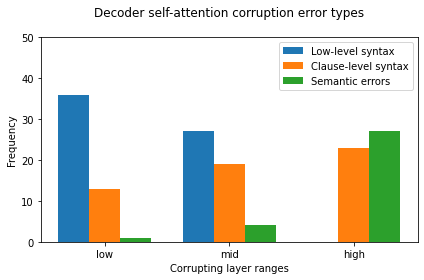

In [345]:
# A1.2.0

groups = ['low', 'mid', 'high']

err_types = {
    'A': "Low-level syntax",
    'B': "Clause-level syntax",
    'C': "Semantic errors",
}
values = [[err_htype_counters[group][err_type] for group in groups] for err_type in err_types.keys()]

# Set up the plot
fig, ax = plt.subplots()
width = 0.25
x = range(len(err_types))

# Plot the bars for each group
for i, (err_type, err_desc) in enumerate(err_types.items()):
    ax.bar([pos + i * width for pos in x], values[i], width=width, label=err_desc)

# Set labels and ticks
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(groups)
ax.set_ylim(top=50)
ax.set_xlabel('Corrupting layer ranges')
ax.set_ylabel('Frequency')
ax.set_title('Decoder self-attention corruption error types\n')
ax.legend()

# Show the plot
fig.tight_layout()
plt.show()


In [347]:
# os.makedirs('/home/yshao/Projects/rome/results/figs/exp-A1.2.0', exist_ok=True)
# fig.savefig('/home/yshao/Projects/rome/results/figs/exp-A1.2.0/error_analysis-htypes.png')

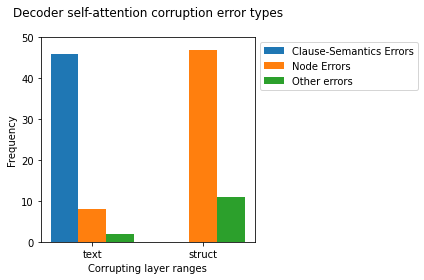

In [395]:
# A1.1.1

groups = ['text', 'struct']

err_types = {
    'S': "Clause-Semantics Errors",
    'N': "Node Errors",
    'O': "Other errors",
}
values = [[err_htype_counters[f'all-{group}'][err_type] for group in groups] for err_type in err_types.keys()]

# Set up the plot
fig, ax = plt.subplots()
width = 0.25
x = range(len(groups))

# Plot the bars for each group
for i, (err_type, err_desc) in enumerate(err_types.items()):
    ax.bar([pos + i * width for pos in x], values[i], width=width, label=err_desc)

# Set labels and ticks
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(groups)
ax.set_ylim(top=50)
ax.set_xlabel('Corrupting layer ranges')
ax.set_ylabel('Frequency')
ax.set_title('Decoder self-attention corruption error types\n')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Show the plot
fig.tight_layout()
plt.show()


In [396]:
os.makedirs('/home/yshao/Projects/rome/results/figs/exp-A1.1.1', exist_ok=True)
fig.savefig('/home/yshao/Projects/rome/results/figs/exp-A1.1.1/error_analysis-htypes.png')

### Node relevance accuracy
- (column)

#### From final SQL

In [210]:
clean_eval_path = os.path.join(f'/home/yshao/Projects/rome/results/clean_predictions/evals.jsonl')

with open(clean_eval_path, 'r') as f:
    clean_sql_results = [json.loads(l) for l in f]

len(clean_sql_results)

1034

In [211]:
clean_sql_results[0]

{'predicted': 'select count(*) from singer',
 'gold': 'select count(*) from singer',
 'predicted_parse_error': False,
 'hardness': 'easy',
 'exact': True,
 'partial': {'select': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'select(no AGG)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'where': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'where(no OP)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 0,
   'pred_total': 0},
  'group(no Having)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 0,
   'pred_total': 0},
  'group': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'order': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'and/or': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 1, 'pred_total': 1},
  'IUEN': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'keywords': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total

In [ ]:
processed_spider_dev[0]

In [241]:
N_all_cols = 0
N_occ_cols = 0

for i, (ex, res_d) in enumerate(zip(processed_spider_dev, clean_sql_results)):
    ex = dict(ex)
    ctu.add_basic_analysis_info(mt_uskg, ex)
    
    g_sql = ex['seq_out']
    type2tok_ranges = ex['type2tok_ranges']
    col_name_counter = ex['col_name_counter']
    tab_name_counter = ex['tab_name_counter']
    
    node_name_counter = col_name_counter + tab_name_counter
    
    for col, cnt in col_name_counter.items():
        if cnt == 1:
#         if True:
            N_all_cols += 1
    
    _occ_cols = set()
    for s, e in type2tok_ranges['column']:
        tok = g_sql[s: e]
        if node_name_counter[tok] == 1:
            _occ_cols.add(tok)
    N_occ_cols += len(_occ_cols)

In [242]:
# cross check with exp4.1-probing 
N_all_cols, N_occ_cols

(16640, 1625)

In [270]:
invalid_ids = []

N_all_cols = 0
N_occ_cols = 0
N_pred_cols = 0

N_corr_cols = 0
N_corr_occ_cols = 0

for i, (ex, res_d) in enumerate(zip(processed_spider_dev, clean_sql_results)):
    ex = dict(ex)
    ctu.add_basic_analysis_info(mt_uskg, ex)
    
    g_sql = ex['seq_out']
    type2tok_ranges = ex['type2tok_ranges']
    col_name_counter = ex['col_name_counter']
    tab_name_counter = ex['tab_name_counter']
    
    node_name_counter = col_name_counter + tab_name_counter
    
    _all_cols = set()
    for col, cnt in col_name_counter.items():
        if cnt == 1:
            _all_cols.add(col)
    
    _occ_cols = set()
    for s, e in type2tok_ranges['column']:
        tok = g_sql[s: e]
        if node_name_counter[tok] == 1:
            _occ_cols.add(tok)
    _non_occ_cols = _all_cols - _occ_cols
    
    p_sql = res_d['predicted']
    
    try:
        p_sql_tok_ranges = ctu.separate_punct_by_offset(p_sql)
        p_sql_rg2type = ctu.categorize_tokens_offset(p_sql, p_sql_tok_ranges)
    except ValueError as e:
        if res_d['predicted_parse_error']:
            invalid_ids.append(i)
            continue
        else:
            raise e
        
    p_sql_type2rgs = defaultdict(list)
    for _rg, _type in p_sql_rg2type.items():
        p_sql_type2rgs[_type].append(_rg)
    
    _pred_cols = set()
    for s, e in p_sql_type2rgs['column']:
        tok = p_sql[s: e]
        if node_name_counter[tok] == 1:
            _pred_cols.add(tok)
    _non_pred_cols = _all_cols - _pred_cols
    
    N_all_cols += len(_all_cols)
    N_occ_cols += len(_occ_cols)
    N_pred_cols += len(_pred_cols)
    N_corr_cols += (len(_occ_cols & _pred_cols) + len(_non_occ_cols & _non_pred_cols))
    N_corr_occ_cols += len(_occ_cols & _pred_cols)


In [271]:
invalid_ids

[101, 700]

In [272]:
{
    'N_all_cols': N_all_cols,
    'N_occ_cols': N_occ_cols,
    'N_pred_cols': N_pred_cols,
    'N_corr_cols': N_corr_cols,
    'N_corr_occ_cols': N_corr_occ_cols,
}

{'N_all_cols': 16620,
 'N_occ_cols': 1620,
 'N_pred_cols': 1564,
 'N_corr_cols': 16358,
 'N_corr_occ_cols': 1457}

In [273]:
Acc = N_corr_cols / N_all_cols
P = N_corr_occ_cols / N_pred_cols
R = N_corr_occ_cols / N_occ_cols
F1 = (2 * P * R) / (P + R + 1e-9)

res_dict = {
    'Acc': Acc,
    'P': P,
    'R': R,
    'F1': F1,
}

for k, v in res_dict.items():
    print(f'{k}\t{v:.4f}')

Acc	0.9842
P	0.9316
R	0.8994
F1	0.9152


In [ ]:
# res_d

In [ ]:
# {
#     'all_cols': _all_cols,
#     'occ_cols': _occ_cols,
#     'non_occ_cols': _non_occ_cols,
#     'pred_cols': _pred_cols,
#     'non_pred_cols': _non_pred_cols,
# }

#### Heuristics: text exact match

In [403]:
invalid_ids = []

N_all_cols = 0
N_occ_cols = 0
N_pred_cols = 0

N_corr_cols = 0
N_corr_occ_cols = 0

for i, (ex, res_d) in enumerate(zip(processed_spider_dev, clean_sql_results)):
    ex = dict(ex)
    ctu.add_basic_analysis_info(mt_uskg, ex)
    
    g_sql = ex['seq_out']
    type2tok_ranges = ex['type2tok_ranges']
    col_name_counter = ex['col_name_counter']
    tab_name_counter = ex['tab_name_counter']
    
    node_name_counter = col_name_counter + tab_name_counter
    
    _all_cols = set()
    for col, cnt in col_name_counter.items():
        if cnt == 1:
            _all_cols.add(col)
    
    _occ_cols = set()
    for s, e in type2tok_ranges['column']:
        tok = g_sql[s: e]
        if node_name_counter[tok] == 1:
            _occ_cols.add(tok)
    _non_occ_cols = _all_cols - _occ_cols
    
    
    col2table = ex['col2table']
    _pred_cols = set()
    for node in _all_cols:
        node_table = col2table[node][0]
        text_match = ctu.check_col_text_match(ex, node, node_table)
        if text_match in ('exact', 'partial'):
            _pred_cols.add(node)
    
    _non_pred_cols = _all_cols - _pred_cols
    
    N_all_cols += len(_all_cols)
    N_occ_cols += len(_occ_cols)
    N_pred_cols += len(_pred_cols)
    N_corr_cols += (len(_occ_cols & _pred_cols) + len(_non_occ_cols & _non_pred_cols))
    N_corr_occ_cols += len(_occ_cols & _pred_cols)


In [404]:
{
    'N_all_cols': N_all_cols,
    'N_occ_cols': N_occ_cols,
    'N_pred_cols': N_pred_cols,
    'N_corr_cols': N_corr_cols,
    'N_corr_occ_cols': N_corr_occ_cols,
}

{'N_all_cols': 16640,
 'N_occ_cols': 1625,
 'N_pred_cols': 2009,
 'N_corr_cols': 15024,
 'N_corr_occ_cols': 1009}

In [405]:
Acc = N_corr_cols / N_all_cols
P = N_corr_occ_cols / N_pred_cols
R = N_corr_occ_cols / N_occ_cols
F1 = (2 * P * R) / (P + R + 1e-9)

res_dict = {
    'Acc': Acc,
    'P': P,
    'R': R,
    'F1': F1,
}

for k, v in res_dict.items():
    print(f'{k}\t{v:.4f}')

Acc	0.9029
P	0.5022
R	0.6209
F1	0.5553


## Tests

### add basic analysis info

In [220]:
ex_id = 111
a_ex_id = 0

ex = dict(processed_spider_dev[ex_id])
ex['text_in'], \
ex['struct_in'], \
ex['seq_out']

('What is the accelerate of the car make amc hornet sportabout (sw)?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker ( amc ) , fullname , country | model_list : modelid , maker , model ( amc ) | car_names : makeid , model ( amc ) , make ( amc hornet , amc hornet sportabout (sw) ) | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make = 'amc hornet sportabout (sw)';")

In [224]:
ex.keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out'])

In [225]:
ctu.add_basic_analysis_info(mt_uskg, ex)

In [226]:
ex.keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out', 'enc_sentence', 'enc_tokenized', 'text_range', 'struct_range', 'parsed_struct_in', 'alias2table', 'col2table', 'col_name_counter', 'tab_name_counter', 'struct_node_ranges_dict', 'sql_tokens', 'sql_token_ranges', 'tok_ranges2type', 'type2tok_ranges'])

### create_analysis_samples

In [221]:
# temp test
# ex['seq_out'] = 'select year from cars_data'

In [ ]:
a_ex_list = ctu.create_analysis_sample_dicts(
                mt_uskg, ex,
                subject_type='column',
                remove_struct_duplicate_nodes=True)

In [ ]:
a_ex_list[a_ex_id].keys()

In [ ]:
a_ex_list[a_ex_id]['alias2table']

In [ ]:
[(d['dec_prompt'], d['expect'], d['node_name_ranges'], d['expect_input_ranges'], '------',\
  d['self_ranges'], d['context_ranges'],\
  d['category'], '------' * 2) for d in a_ex_list]

In [ ]:
d = dict(a_ex_list[a_ex_id])
d

In [ ]:
d = ctu.add_clean_prediction(mt_uskg, d)

In [ ]:
d

#### parse_sql_alias2table

In [185]:
_sql = 'SELECT t2.aaa , t3.ccc FROM table_name as t1 JOIN other_table as t2 on table_name.a_a = other_table.b_a JOIN ttt as t3 on other_table.asth = ttt.asth'
ctu.parse_sql_alias2table(_sql)

{'t1': 'table_name', 't2': 'other_table', 't3': 'ttt'}

#### for syntax

In [861]:
_sql = 'SELECT t2.aaa, DISTINCT(t3.ccc), COUNT(*) FROM table_name as t1 JOIN other_table as t2 on table_name.a_a = other_table.b_a JOIN ttt as t3 on other_table.asth = ttt.asth WHERE t2.col like %hey%'.lower()
prompts = ctu.make_syntax_dec_prompt(_sql, '%', is_punct=True)
prompts

['select t2.aaa, distinct(t3.ccc), count(*) from table_name as t1 join other_table as t2 on table_name.a_a = other_table.b_a join ttt as t3 on other_table.asth = ttt.asth where t2.col like',
 'select t2.aaa, distinct(t3.ccc), count(*) from table_name as t1 join other_table as t2 on table_name.a_a = other_table.b_a join ttt as t3 on other_table.asth = ttt.asth where t2.col like %hey']

In [875]:
a_ex_list_syntax = ctu.create_syntax_analysis_sample_dicts(
                mt_uskg, ex)

AssertionError: ('.', ['select', 't1', '.', 'accelerate', 'from', 'cars_data', 'as', 't1', 'join', 'car_names', 'as', 't2', 'on', 't1', '.', 'id', '=', 't2', '.', 'makeid', 'where', 't2', '.', 'make', '=', "'", 'amc', 'hornet', 'sportabout', '(', 'sw', ')', "'", ';'])

### context_ranges

In [249]:
a_ex = dict(a_ex_list[0])
a_ex['text_in'], a_ex['struct_in'], a_ex['seq_out'], a_ex['expect']

('What is the name of the different car makers who produced a car in 1970?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select year from cars_data',
 'year')

In [250]:
a_ex['alias2table']

{}

In [256]:
text_range = a_ex['text_range']
struct_range = a_ex['struct_range']

# For full context tokens, use [0, L] and [R, -1]
# L: node left max end index ; R: node right min start index

token_ranges_dict = a_ex['token_ranges_dict']
_all_node_range_lists = list(token_ranges_dict['col_name_ranges'].values()) + list(token_ranges_dict['table_name_ranges'].values()) + list(token_ranges_dict['db_id_ranges'].values())
_all_node_ranges = [rg
                    for rg_list in _all_node_range_lists
                    for rg in rg_list]
_all_left_endpoint = [s for s, e in _all_node_ranges] + [struct_range[1]]
_all_right_endpoint = [e for s, e in _all_node_ranges] + [struct_range[0]]
# TODO: pull this part out to the shared function (e.g. create_analysis_sample_dicts)
# TODO: test for columns on ends

expect_input_ranges = a_ex['expect_input_ranges']    # list of ranges of node-of-interest (code allows dup)
# tok_indices = [i for s, e in expect_input_ranges for i in range(s, e)]
# expect_input_indices = [i for s, e in expect_input_ranges for i in range(s, e)]
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
# node = a_ex['expect']

context_range_endpoints = [struct_range[0]]
self_range_endpoints = []       # This is different from `expect_input_ranges`: this includes boundary toks
for tok_s, tok_e in expect_input_ranges:
    _l = max([e for e in _all_right_endpoint if e <= tok_s])
    _r = min([s for s in _all_left_endpoint if s >= tok_e])
    context_range_endpoints.extend([_l, _r])
    self_range_endpoints.extend([_l, _r])
context_range_endpoints.append(struct_range[1])

self_ranges = [(self_range_endpoints[i], self_range_endpoints[i+1])
                for i in range(0, len(self_range_endpoints), 2)]
self_tok_indices = [i for s, e in self_ranges for i in range(s, e)]

context_ranges = [(context_range_endpoints[i], context_range_endpoints[i+1])
                    for i in range(0, len(context_range_endpoints), 2)]
context_ranges = [(s, e) for s, e in context_ranges if e > s]
context_tok_indices = corrupt_tok_indices = [i for s, e in context_ranges for i in range(s, e)]

text_tok_indices = list(range(*text_range))


In [257]:
self_ranges, context_ranges

([(137, 140)], [(24, 137)])

In [ ]:
context_tok_indices

In [265]:
for s, e in self_ranges:
    _piece = tokenizer.decode(a_ex['enc_tokenized']['input_ids'][s : e])
    print(_piece)

, year


In [254]:
for s, e in context_ranges:
    _piece = tokenizer.decode(a_ex['enc_tokenized']['input_ids'][s : e])
    print(_piece)

| car_1 | continents : contid, continent | countries : countryid, countryname, continent | car_makers : id, maker, fullname, country | model_list : modelid, maker, model | car_names : makeid, model, make | cars_data : id, mpg, cylinders, edispl, horsepower, weight, accelerate



### run_uskg_forward

In [89]:
a_ex = dict(a_ex_list[a_ex_id])

In [90]:
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
expect = a_ex['expect']

In [91]:
enc_sentence, dec_prompt, expect

('What is the name of the different car makers who produced a car in 1970?; structed knowledge: | car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select distinct t1.maker from car_makers as t1 join model_list as t2 on t1.id = t2.maker join car_names as t3 on t2.model = t3.model join cars_data as t4 on t3.',
 'makeid')

In [318]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 11,
    [dec_prompt] * 11,
    answer=expect)

In [320]:
_out = ctu.run_model_forward_uskg(mt_uskg.model, **inp, output_attentions=True)

In [322]:
_out.__dict__.keys()

dict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions'])

In [329]:
# layers, (bsz, n_heads, seq_len, seq_len + prev_len)
len(_out.encoder_attentions), _out.encoder_attentions[0].size()

(24, torch.Size([11, 16, 141, 151]))

In [330]:
# layers, (bsz, n_heads, prompt_len, seq_len + prev_len)
len(_out.cross_attentions), _out.cross_attentions[0].size()

(24, torch.Size([11, 16, 2, 151]))

In [331]:
# layers, (bsz, n_heads, prompt_len, prompt_len + prev_len)
len(_out.decoder_attentions), _out.decoder_attentions[0].size()

(24, torch.Size([11, 16, 2, 12]))

In [339]:
inp.keys()

dict_keys(['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'])

### trace

In [207]:
a_ex = dict(a_ex_list[a_ex_id])
a_ex = ctu.add_clean_prediction(mt_uskg, a_ex)

In [208]:
result = ctu.make_basic_result_dict(a_ex)
result

{'enc_sentence': 'Which city has the most frequent destination airport?; structed knowledge: | flight_2 | airlines : uid , airline , abbreviation , country | airports : city , airportcode , airportname , country , countryabbrev | flights : airline , flightno , sourceairport , destairport',
 'seq_out': 'select t1.city from airports as t1 join flights as t2 on t1.airportcode = t2.destairport group by t1.city order by count(*) desc limit 1',
 'dec_prompt': 'select t1.city from airports as t1 join flights as t2 on t1.airportcode = t2.destairport group by t1.',
 'expect': 'city',
 'expect_type': 'column',
 'db_id': 'flight_2',
 'expect_input_ranges': [(45, 46)],
 'expect_table': 'airports',
 'answer': 'city',
 'base_score': 0.9983423948287964,
 'answers_t': [6726],
 'correct_prediction': True,
 'category': {'sql_hardness': 'extra',
  'node_role': 'group by',
  'text_match': 'exact'}}

In [209]:
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
expect = a_ex['expect']
answer = result['answer']
answers_t = result['answers_t']

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 11,
    [dec_prompt] * 11,
    answer=expect)

text_range = a_ex['text_range']
struct_range = a_ex['struct_range']

self_ranges = a_ex['self_ranges']
context_ranges = a_ex['context_ranges']

self_tok_indices = [i for s, e in self_ranges for i in range(s, e)]
context_tok_indices = corrupt_tok_indices = [i for s, e in context_ranges for i in range(s, e)]
text_tok_indices = list(range(*text_range))
struct_tok_indices = list(range(*struct_range))

In [210]:
_score = ctu.trace_with_repatch_uskg(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
#                     for tnum in range(*struct_range)],
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_tok_indices,
    tokens_to_mix_individual_indices=True,
    replace=True,
).item()

In [211]:
answers_t, answer, _score

([6726], 'city', 0.8450507521629333)

In [212]:
states_to_corrupt = [(tnum, ctu.layername_uskg(mt_uskg.model, "encoder", 0, "embed"))
                for tnum in text_tok_indices]

_score = ctu.trace_with_repatch_uskg(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    states_to_corrupt=states_to_corrupt,
#     tokens_to_mix=corrupt_tok_indices,
#     tokens_to_mix_individual_indices=True,
    replace=True,
).item()
_score

0.8450507521629333

In [213]:
# Pair of identical input to test correctness 

_score = ctu.trace_with_repatch_uskg(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', l))
#                     for tnum in text_tok_indices for l in range(mt_uskg.num_enc_layers - 1)],
    states_to_patch=[],
    states_to_patch_1st_pass=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', 12))
                    for tnum in text_tok_indices],
    states_to_unpatch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', 23))
                    for tnum in struct_tok_indices],
    answers_t=answers_t,
    tokens_to_mix=text_tok_indices,
    tokens_to_mix_individual_indices=True,
    tokens_to_mix_1st_pass=context_tok_indices,
    replace=True,
).item()

_score

tensor(0.9952, device='cuda:0')

In [214]:
_score = ctu.trace_with_repatch_uskg(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', l))
#                     for tnum in text_tok_indices for l in range(mt_uskg.num_enc_layers - 1)],
    states_to_patch=[],
    states_to_patch_1st_pass=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', 12))
                    for tnum in text_tok_indices],
    states_to_unpatch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', 23))
                    for tnum in struct_tok_indices],
    answers_t=answers_t,
    states_to_corrupt=[(tnum, ctu.layername_uskg(mt_uskg.model, "encoder", 0, "embed"))
                    for tnum in text_tok_indices],
    states_to_corrupt_1st_pass=[(tnum, ctu.layername_uskg(mt_uskg.model, "encoder", 0, "embed"))
                    for tnum in context_tok_indices],
    replace=True,
).item()

_score

tensor(0.9952, device='cuda:0')

In [215]:
# Test corrupting attention 
_score = ctu.trace_with_repatch_uskg(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', l))
#                     for tnum in text_tok_indices for l in range(mt_uskg.num_enc_layers - 1)],
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    states_to_corrupt=[(tnum, ctu.layername_uskg(mt_uskg.model, "encoder", l, "self_attn"))
                    for tnum in text_tok_indices for l in range(mt_uskg.num_enc_layers)],
    replace=True,
).item()

_score

0.7253002524375916

In [ ]:
[n for n, w in mt_uskg.model.named_parameters()]

In [216]:
vocab_probs = ctu.run_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
#                     for tnum in range(*struct_range)],
    states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', l))
                    for tnum in self_tok_indices for l in range(mt_uskg.num_enc_layers - 1)],
    states_to_unpatch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
                    for tnum in self_tok_indices],
    answer_len=len(answers_t),
    tokens_to_mix=corrupt_tok_indices,
    tokens_to_mix_individual_indices=True,
    replace=True,
)

In [217]:
vocab_probs.size()

torch.Size([1, 32102])

In [218]:
torch.max(vocab_probs, dim=-1)

torch.return_types.max(
values=tensor([1.], device='cuda:0'),
indices=tensor([7634], device='cuda:0'))

In [219]:
vocab_probs[0, 7634]

tensor(1., device='cuda:0')

In [220]:
vocab_probs

tensor([[2.2642e-25, 1.2223e-15, 7.3942e-18,  ..., 9.1578e-20, 2.6884e-39,
         2.8131e-39]], device='cuda:0')

### trace - partial edit

#### single attention layer

In [385]:
from uskg.models.prompt.modeling_t5 import T5Attention

In [ ]:
_t5_config = copy.deepcopy(mt_uskg.model.config)
_t5_config.d_model = 10
_t5_config.d_kv = 4
_t5_config.num_heads = 3
_t5_config

In [387]:
test_attn_module = T5Attention(config=_t5_config)
test_attn_module.eval()
test_attn_module

T5Attention(
  (q): Linear(in_features=10, out_features=12, bias=False)
  (k): Linear(in_features=10, out_features=12, bias=False)
  (v): Linear(in_features=10, out_features=12, bias=False)
  (o): Linear(in_features=12, out_features=10, bias=False)
)

In [388]:
[(k, v.size()) for k, v in test_attn_module.named_parameters()]

[('q.weight', torch.Size([12, 10])),
 ('k.weight', torch.Size([12, 10])),
 ('v.weight', torch.Size([12, 10])),
 ('o.weight', torch.Size([10, 12]))]

In [389]:
[k for k, v in test_attn_module.named_modules()]

['', 'q', 'k', 'v', 'o']

In [426]:
_test_bs = 1
_test_seqlen = 7
_test_prevlen = 2

_test_h = torch.randn(_test_bs, _test_seqlen, _t5_config.d_model)
# _test_h[:, 0] = 999.0
_test_prefix = {
    'prev_key': torch.randn(_test_bs, _t5_config.num_heads, _test_prevlen, _t5_config.d_kv),
    'prev_value': torch.randn(_test_bs, _t5_config.num_heads, _test_prevlen, _t5_config.d_kv),
    'prev_key_padding_mask': torch.zeros(_test_bs, _test_prevlen).bool()
}
_test_h.size(), [(k, v.size()) for k, v in _test_prefix.items()]

(torch.Size([1, 7, 10]),
 [('prev_key', torch.Size([1, 3, 2, 4])),
  ('prev_value', torch.Size([1, 3, 2, 4])),
  ('prev_key_padding_mask', torch.Size([1, 2]))])

In [427]:
_test_h

tensor([[[ 0.8561, -0.0552,  0.3845,  1.1441, -1.2765, -0.6869, -0.9646,
          -1.0255, -2.3659, -1.7153],
         [ 1.0685, -0.1617,  0.8310, -1.7257,  0.3674,  1.7559,  0.5763,
          -0.9344,  0.9016,  0.7490],
         [-1.1887, -1.0820, -0.5925,  0.7623, -0.6538, -0.0067,  0.5618,
           1.3310,  1.2580, -0.6973],
         [ 0.2807,  0.0763, -0.3539,  0.9494, -0.1557, -0.7645, -0.2103,
          -1.0175, -0.3029, -0.0376],
         [ 0.0984,  0.5610, -2.3323,  1.3421, -1.0381, -1.8568, -0.7754,
          -1.6037,  0.2501, -1.4155],
         [-1.4474, -0.4784,  0.0972, -0.3393,  1.2340,  0.7611, -0.4786,
           0.0506, -0.1188,  2.7051],
         [ 2.0642, -0.0186, -0.8283,  1.0852,  0.9819, -0.4044,  0.9831,
          -0.2723,  0.2037,  1.6401]]])

In [428]:
_test_prefix

{'prev_key': tensor([[[[-2.2578,  0.2019,  0.3287,  0.3906],
           [-1.2143, -0.7039, -1.0298,  0.1425]],
 
          [[ 0.3967,  1.5168,  0.0967,  1.4454],
           [ 0.1648,  0.2483,  1.5992,  1.2469]],
 
          [[ 1.3875,  0.4460, -0.2676, -1.2290],
           [ 2.0209,  1.1736,  0.8446,  0.8827]]]]),
 'prev_value': tensor([[[[ 0.8351,  1.2052,  1.4187, -0.5358],
           [-1.4274,  0.2792,  2.0149,  1.3695]],
 
          [[-0.0379,  1.8999, -0.4236, -0.9176],
           [ 1.5794,  1.1735, -0.2925,  2.2855]],
 
          [[ 1.1935,  0.9343, -0.5582,  0.8163],
           [-1.3765,  0.4046,  1.0941,  0.4058]]]]),
 'prev_key_padding_mask': tensor([[False, False]])}

In [429]:
_test_mask = torch.zeros(1, 1, 1, _test_seqlen)

In [ ]:
_out = test_attn_module.forward(
    _test_h,
    mask=_test_mask,
    prefix=_test_prefix,
    output_attentions=True,
)

In [ ]:
_out

In [432]:
_out[3].sum(-1)

tensor([[[0.3544, 0.3264, 0.2939, 0.3878, 0.4695, 0.2997, 0.1775],
         [0.4028, 0.1655, 0.2949, 0.5148, 0.4162, 0.4189, 0.4683],
         [0.5839, 0.4639, 0.1393, 0.4925, 0.6272, 0.1917, 0.4634]]])

In [433]:
def _test_mask_attention(att, mix_mask):
    # token 4,5,6 (in real_seq) not attending to 2 (in full_seq, i.e. 0 in real_seq)
    # att: (bs, n_head, real_seq, full_seq)
#     att[:, :, 4:, 2] = 0.0

    _zero = torch.tensor(0, dtype=att.dtype)
    att = torch.where(mix_mask, _zero, att)

    print(att)
    return att

In [434]:
mix_mask = torch.zeros(1, 1, _test_seqlen, _test_seqlen + _test_prevlen, dtype=bool)
mix_mask[:, :, ::2, ::2] = 1

mix_mask_2 = torch.zeros(1, 1, _test_seqlen, _test_seqlen + _test_prevlen, dtype=bool)
mix_mask_2[:, :, :, :_test_prevlen] = 1
mix_mask_2[:, :, 3:, _test_prevlen : _test_prevlen+3] = 1
mix_mask_2[:, :, :3, _test_prevlen+3 :] = 1

mix_mask, mix_mask_2

(tensor([[[[ True, False,  True, False,  True, False,  True, False,  True],
           [False, False, False, False, False, False, False, False, False],
           [ True, False,  True, False,  True, False,  True, False,  True],
           [False, False, False, False, False, False, False, False, False],
           [ True, False,  True, False,  True, False,  True, False,  True],
           [False, False, False, False, False, False, False, False, False],
           [ True, False,  True, False,  True, False,  True, False,  True]]]]),
 tensor([[[[ True,  True, False, False, False,  True,  True,  True,  True],
           [ True,  True, False, False, False,  True,  True,  True,  True],
           [ True,  True, False, False, False,  True,  True,  True,  True],
           [ True,  True,  True,  True,  True, False, False, False, False],
           [ True,  True,  True,  True,  True, False, False, False, False],
           [ True,  True,  True,  True,  True, False, False, False, False],
        

In [ ]:
mix_mask | mix_mask_2

In [435]:
test_attn_module.ext_attention_weights_fn = lambda att : _test_mask_attention(att, mix_mask_2)

In [436]:
print(test_attn_module.ext_attention_weights_fn)
print(test_attn_module.ext_attention_logits_fn)

<function <lambda> at 0x7fc33d6065e0>
None


In [ ]:
_out = test_attn_module.forward(
    _test_h,
    mask=_test_mask,
    prefix=_test_prefix,
    output_attentions=True,
)

In [ ]:
_out

#### full model

In [438]:
a_ex = dict(a_ex_list[a_ex_id])
a_ex = ctu.add_clean_prediction(mt_uskg, a_ex)

In [439]:
result = ctu.make_basic_result_dict(a_ex)
result

{'enc_sentence': 'What is the accelerate of the car make amc hornet sportabout (sw)?; structed knowledge: | car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker ( amc ) , fullname , country | model_list : modelid , maker , model ( amc ) | car_names : makeid , model ( amc ) , make ( amc hornet , amc hornet sportabout (sw) ) | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'seq_out': "select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make = 'amc hornet sportabout (sw)';",
 'dec_prompt': 'select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.',
 'expect': 'make',
 'expect_type': 'column',
 'db_id': 'car_1',
 'expect_input_ranges': [(121, 145)],
 'expect_table': 'car_names',
 'answer': 'make',
 'base_score': 0.9998800754547119,
 'answers_t': [19509],
 'correct_prediction': True,
 'category': {'sql_hardness':

In [440]:
enc_sentence = a_ex['enc_sentence']
dec_prompt = a_ex['dec_prompt']
expect = a_ex['expect']
answer = result['answer']
answers_t = result['answers_t']

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 2,
    [dec_prompt] * 2,
    answer=expect)

text_range = a_ex['text_range']
struct_range = a_ex['struct_range']

self_ranges = a_ex['self_ranges']
context_ranges = a_ex['context_ranges']

self_tok_indices = [i for s, e in self_ranges for i in range(s, e)]
context_tok_indices = corrupt_tok_indices = [i for s, e in context_ranges for i in range(s, e)]
text_tok_indices = list(range(*text_range))
struct_tok_indices = list(range(*struct_range))

In [441]:
_score = ctu.trace_with_repatch_uskg(
    model=mt_uskg.model,
    inp=inp,
#     states_to_patch=[(tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
#                     for tnum in range(*struct_range)],
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=context_tok_indices,
    tokens_to_mix_individual_indices=True,
    replace=True,
).item()

In [442]:
answers_t, answer, _score

([19509], 'make', 0.9987825751304626)

In [451]:
_score = ctu.trace_attention_manip_uskg_multi_token(
# _probs = ctu.run_attention_manip_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
#     answer_len=len(answers_t),
    answers_t=answers_t,
#     states_to_patch=[],
    layers_to_mix=[ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(24)],
    src_tokens_to_mix=text_tok_indices + struct_tok_indices, # src doesn't have prefix 
#     src_tokens_to_mix=[-1],
    tgt_tokens_to_mix=list(range(10)) + [i + 10 for i in text_tok_indices + struct_tok_indices],  # tgt has prefix 
)

In [452]:
_probs.max(dim=-1)
# _score

torch.return_types.max(
values=tensor([0.6447], device='cuda:0'),
indices=tensor([4350], device='cuda:0'))

In [453]:
mt_uskg.tokenizer.decode([4350])

'name'

In [110]:
# ctu.layername_uskg(mt_uskg.model, 'encoder', 0, 'self_attn')

### utils

### Edit - attention

#### Encoder mask (toy example)

In [100]:
ex['text_range'] = (0, 3)
ex['struct_range'] = (5, 10)
ex['enc_sentence'] = "what is? empty empty Table column column Table column"
ex['struct_node_ranges_dict'] = None

In [101]:
mt_uskg.tokenizer_uskg.tokenize(ex['enc_sentence'])

['▁what',
 '▁is',
 '?',
 '▁empty',
 '▁empty',
 '▁Table',
 '▁column',
 '▁column',
 '▁Table',
 '▁column']

In [102]:
ex.keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out', 'text_range', 'struct_range', 'enc_sentence', 'struct_node_ranges_dict'])

In [103]:
ex['text_range'], ex['struct_range']

((0, 3), (5, 10))

In [104]:
mix_mask = build_enc_self_attention_mask_for_section_pair(
    ex,
    q_sect='text',
    k_sect='text',
    seq_len=None,
    mt=mt_uskg,
    prefix_len=2)

In [105]:
print(mix_mask.to(int))

tensor([[[[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]])


In [108]:
mix_mask = build_dec_cross_attention_mask_for_section(
    ex,
    k_sect='others',
    seq_len=None,
    mt=mt_uskg,
    prefix_len=2)

In [109]:
print(mix_mask.to(int))

tensor([[[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]]]])


#### Actual prediction

In [165]:
ex['text_in'], \
ex['struct_in'], \
ex['seq_out']

('What is the accelerate of the car make amc hornet sportabout (sw)?',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker ( amc ) , fullname , country | model_list : modelid , maker , model ( amc ) | car_names : makeid , model ( amc ) , make ( amc hornet , amc hornet sportabout (sw) ) | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 "select t1.accelerate from cars_data as t1 join car_names as t2 on t1.id = t2.makeid where t2.make = 'amc hornet sportabout (sw)';")

In [166]:
pred = pred_sql(mt_uskg, ex, padding=False)
pred

'select t1.accelerate from cars_data as t1 join car_names as t2 on t1.make = t2.makeid where t2.make = "amc hornet sportabout"'

In [116]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(24)]
section_pairs = [('all', 'all')]

with add_enc_attention_edit(mt=mt_uskg,
                        ex=ex,
                        mix_layers=mix_layers,
                        section_pairs=section_pairs,
                        attn_corrupt_type='weights'):

    pred = pred_sql(mt_uskg, ex, padding=False)

pred

'select t1.name from car as t1 join t2 on t1.car = t2.caravan (select t2.caravan from car as t1 join t2 on t1.car = t2.caravan where t1.year = _2010'

In [117]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(6, 18)]
section_pairs = [('struct', 'text')]

with add_enc_attention_edit(mt=mt_uskg,
                        ex=ex,
                        mix_layers=mix_layers,
                        section_pairs=section_pairs,
                        attn_corrupt_type='weights'):

    pred = pred_sql(mt_uskg, ex, padding=False)

pred

'select t1.accelerate from cars_data as t1 join car_names as t2 on t1.make = t2.makeid where t2.make = "amc hornet sportabout" (sw)'

In [124]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'decoder', l, 'cross_attn') for l in range(24)]
sections = ['prefix']

with add_dec_cross_attention_edit(mt=mt_uskg,
                        ex=ex,
                        mix_layers=mix_layers,
                        sections=sections,
                        attn_corrupt_type='weights'):

    pred = pred_sql(mt_uskg, ex, padding=False)

pred

tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, Fal

'cars_data: accelerated = 0-60 seconds, t1.speed = 0-60 seconds, t1.year = 00 and t1.year = 00'

In [189]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'decoder', l, 'self_attn') for l in range(23, 24)]

with add_dec_self_attention_edit(mt=mt_uskg,
                                ex=ex,
                                mix_layers=mix_layers,
                                attn_corrupt_type='weights'):

    pred = pred_sql(mt_uskg, ex, padding=False)

pred

'select t1.accelerate from cars_data as t1 join car_names as t2 on t1.makeid = t2.makeid where t2.make = "ammc hornet sportabout"'

In [172]:
'select t1.accelerate from cars_data as t1 join car_names as t2 on t1.make = t2.makeid where t2.make = "amc hornet sportabout"'

'select t1.accelerate from cars_data as t1 join car_names as t2 on t1.make = t2.makeid where t2.make = "amc hornet sportabout"'

In [ ]:
# text_in = ex['text_in']
# struct_in = ex['struct_in']

# enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
# enc_tokenized = mt_uskg.tokenizer(enc_sentence)
# ex['enc_sentence'] = enc_sentence
# ex['enc_tokenized'] = enc_tokenized

# parsed_struct_in = ctu.parse_struct_in(struct_in)

# token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, ex)
# text_range = ex['text_range']
# struct_range = ex['struct_range']

## Temp

### tokenizer

In [55]:
tokenizer = mt_uskg.tokenizer

In [56]:
s = "mary: has a little  lambbb"
s_ = "mary: has a little lambbb"
tokenizer.tokenize(s), tokenizer.tokenize(s_)

(['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'],
 ['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'])

In [428]:
t = tokenizer(s)
t

{'input_ids': [3157, 63, 10, 65, 3, 9, 385, 17871, 115, 115, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [429]:
list(enumerate(t.tokens()))

[(0, '▁mar'),
 (1, 'y'),
 (2, ':'),
 (3, '▁has'),
 (4, '▁'),
 (5, 'a'),
 (6, '▁little'),
 (7, '▁lamb'),
 (8, 'b'),
 (9, 'b'),
 (10, '</s>')]

In [430]:
t.word_to_tokens(4)

TokenSpan(start=7, end=10)

In [431]:
ctu.decode_sentences(tokenizer, t['input_ids'][7:10])

'lambbb'

In [ ]:
"(a(a)a)".rindex(")"), "(a(a)a)".index(")")

In [ ]:
s = """| concert_singer | singer : singer_id , name ( First Last ) , country ( France , Germany , United States ) , \
song_name , song_release_year , age , is_male"""

tokenizer.tokenize(s)

In [269]:
tokenizer.decode([10])

':'

### Test struct_in parsing

In [66]:
_struct_in = """| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , \
average | singer : singer_id , name ( First Last ) , country ( France , Germany , United States ) , \
song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , \
stadium_id , year ( 2008 , 2012 , 2022 ) | singer_in_concert : concert_id , singer_id"""

In [71]:
ctu.parse_struct_in(_struct_in)

[((3, 'stadium'),
  [[(5, 'stadium_id'), []],
   [(7, 'location'), []],
   [(9, 'name'), []],
   [(11, 'capacity'), []],
   [(13, 'highest'), []],
   [(15, 'lowest'), []],
   [(17, 'average'), []]]),
 ((19, 'singer'),
  [[(21, 'singer_id'), []],
   [(23, 'name'), [(25, 'First Last')]],
   [(29, 'country'), [(31, 'France'), (33, 'Germany'), (35, 'United States')]],
   [(39, 'song_name'), []],
   [(41, 'song_release_year'), []],
   [(43, 'age'), []],
   [(45, 'is_male'), []]]),
 ((47, 'concert'),
  [[(49, 'concert_id'), []],
   [(51, 'concert_name'), []],
   [(53, 'theme'), []],
   [(55, 'stadium_id'), []],
   [(57, 'year'), [(59, '2008'), (61, '2012'), (63, '2022')]]]),
 ((66, 'singer_in_concert'),
  [[(68, 'concert_id'), []], [(70, 'singer_id'), []]])]

In [84]:
_text_in = text_in

enc_sentence = f"{_text_in}; structed knowledge: {_struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

In [85]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], _struct_in)

In [ ]:
token_ranges_dict

In [ ]:
for d_key, d in token_ranges_dict.items():
    for name, ranges in d.items():
        for s, e in ranges:
            recs_name = ctu.decode_sentences(mt_uskg.tokenizer, enc_tokenized['input_ids'][s:e])
            print(f'{d_key}\t{name}\t{recs_name}')

### Torch

In [90]:
_cond = torch.eye(2).to(dtype=bool).view(1, 1, 4)
_cond

tensor([[[ True, False, False,  True]]])

In [91]:
_ones = torch.ones(2, 2, 4)
_zeros = torch.zeros(2, 2, 4)

torch.where(_cond, _ones, _zeros)

tensor([[[1., 0., 0., 1.],
         [1., 0., 0., 1.]],

        [[1., 0., 0., 1.],
         [1., 0., 0., 1.]]])

### Discarded

In [ ]:
# adapted from play_pred()

def pred_sql_with_edit(mt, ex, f_hook_fn=None, p_hook_fn=None):
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    txt = f"{text_in}; structed knowledge: {struct_in}"
    
    tokenized_txt = mt.tokenizer_uskg([txt], max_length=1024, padding="max_length", truncation=True)
    
    device = mt.model.device
    
    all_hooks = []
    if f_hook_fn is not None:
        f_hook = mt.model.register_forward_hook(f_hook_fn)
        all_hooks.append(f_hook)
    if p_hook_fn is not None:
        p_hook = mt.model.register_forward_pre_hook(p_hook_fn)
        all_hooks.append(p_hook)
    
    pred = mt.tokenizer_uskg.batch_decode(
      mt.model.generate(
        torch.tensor(tokenized_txt.data['input_ids'], dtype=int, device=device),
        torch.tensor(tokenized_txt.data['attention_mask'], dtype=int, device=device),
        num_beams=1, 
        max_length=256
        ), 
      skip_special_tokens=True 
    )
    
    for hook in all_hooks:
        hook.remove()
    
    return pred[0]


In [ ]:
# Unused implementation 

def build_enc_self_attention_global_mask(
    ex,
    seq_len=None,
    mt=None,
    prefix_len=10,
    use_self_node=False):
    
    """
    BBB
    For attention-related experiments: build encoder self-attention masks across sections
    ("global" means it is not specific to certain node, i.e. "self" means each node itself)

    Args:
    a_ex (Dict)
    seq_len (int): sequence length
    prefix_len (int): prefix length
    use_self_node (bool): whether to include "self" and "context" related sections
    
    """

    enc_sentence = ex['enc_sentence']

    text_range = ex['text_range']
    struct_range = ex['struct_range']
    text_st, text_ed = text_range
    struct_st, struct_ed = struct_range
    # text_tok_indices = list(range(*text_range))
    # struct_tok_indices = list(range(*struct_range))
    
    token_ranges_dict = ex['struct_node_ranges_dict']

#     if use_self_node:
#         expect_input_ranges = a_ex['expect_input_ranges']
#         tok_indices = [i for s, e in expect_input_ranges for i in range(s, e)]

#         self_ranges = a_ex['self_ranges']
#         struct_context_ranges = a_ex['context_ranges']

#         self_tok_indices = [i for s, e in self_ranges for i in range(s, e)]
#         struct_context_tok_indices = [i for s, e in struct_context_ranges for i in range(s, e)]

#         self_tok_indices_tgt_side = [i + prefix_len for i in self_tok_indices]
#         struct_context_tok_indices_tgt_side = [i + prefix_len for i in struct_context_tok_indices]

    if seq_len is None:
        # need to tokenize and decide seq_len
        # TODO: untested!
        assert mt is not None
        _tok_ids = mt.tokenizer.encode(enc_sentence, add_special_tokens=True)
        seq_len = len(_tok_ids)

    att_mix_mask_dict = dict()
    # key: (q_sect, k_sect)
    # mix_mask: (batch, head, src_len, tgt_len)
    
    t2s_mask = torch.zeros(1, 1, seq_len, seq_len + prefix_len).bool()
    t2s_mask[:, :, text_st : text_ed, struct_st + prefix_len : struct_ed + prefix_len] = True
    att_mix_mask_dict[('text', 'struct')] = t2s_mask

    s2t_mask = torch.zeros_like(t2s_mask).bool()
    s2t_mask[:, :, struct_st : struct_ed, text_st + prefix_len : text_ed + prefix_len] = True
    att_mix_mask_dict[('struct', 'text')] = s2t_mask

#     att_mix_mask_dict['t<->s'] = t2s_mask | s2t_mask

    t2p_mask = torch.zeros_like(t2s_mask).bool()
    t2p_mask[:, :, text_st : text_ed, :prefix_len] = True
    att_mix_mask_dict[('text', 'prefix')] = t2p_mask

    s2p_mask = torch.zeros_like(t2s_mask).bool()
    s2p_mask[:, :, struct_st : struct_ed, :prefix_len] = True
    att_mix_mask_dict[('struct', 'prefix')] = s2p_mask

#     att_mix_mask_dict['ts->p'] = t2p_mask | s2p_mask

    # ADDED: section self-attention
    t2t_mask = torch.zeros_like(t2s_mask).bool()
    t2t_mask[:, :, text_st : text_ed, text_st + prefix_len : text_ed + prefix_len] = True
    att_mix_mask_dict[('text', 'text')] = t2t_mask

    s2s_mask = torch.zeros_like(t2s_mask).bool()
    s2s_mask[:, :, struct_st : struct_ed, struct_st + prefix_len : struct_ed + prefix_len] = True
    att_mix_mask_dict[('struct', 'struct')] = s2s_mask

    if use_self_node:
        # TODO: self->self, self->context 
        # iterate through node ranges 
        NotImplemented
        
        
#         # ADDED: regarding struct context
#         # Notice that it's ok to have 1 list in indexing, but not ok to have 2
#         # If there are 2 lists, it will become a "gather()" which treats the 2 lists in a zipped way
#         s2c_mask = torch.zeros_like(t2s_mask).bool()
#         s2c_mask[:, :, struct_st : struct_ed, struct_context_tok_indices_tgt_side] = True
#         att_mix_mask_dict['s->c'] = s2c_mask

#         c2p_mask = torch.zeros_like(t2s_mask).bool()
#         c2p_mask[:, :, struct_context_tok_indices, :prefix_len] = True
#         att_mix_mask_dict['c->p'] = c2p_mask

#         # c2t: skipped, as already see even s2t is not so effective

#         c2s_mask = torch.zeros_like(t2s_mask).bool()
#         c2s_mask[:, :, struct_context_tok_indices, struct_st + prefix_len : struct_ed + prefix_len] = True
#         att_mix_mask_dict['c->s'] = c2s_mask

#         c2c_mask = c2s_mask.clone()
#         c2c_mask[:, :, :, self_tok_indices_tgt_side] = False
#         assert c2c_mask.sum().item() == len(struct_context_tok_indices) ** 2, \
#             (c2c_mask.sum().item(), len(struct_context_tok_indices) ** 2)
#         att_mix_mask_dict['c->c'] = c2c_mask

    att_mix_mask_dict[('all', 'all')] = torch.ones_like(t2s_mask).bool()

    return att_mix_mask_dict


In [33]:
# Old hook-based implementation of exp A1.0 

# def add_attention_edit_hook(mt, ex, mix_layers, section_pairs, attn_corrupt_type='weights'):
#     """ 
#     Args:
#         mix_layers: List[int], the layers to edit
#         section_pairs: List[Tuple(str, str)]: corrupting attention from which to which
#             sections: "text", "struct", "prefix", "eos"; "self", "context"
#             (notice that "self" is per-node; "context->context" is invalid here)
#         attn_corrupt_type: (same as trace exp) weights / logits 
#     """
    
#     ex = copy.deepcopy(ex)
    
#     text_in = ex['text_in']
#     struct_in = ex['struct_in']

#     enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
#     enc_tokenized = mt.tokenizer(enc_sentence)
#     ex['enc_sentence'] = enc_sentence
#     ex['enc_tokenized'] = enc_tokenized
    
#     parsed_struct_in = ctu.parse_struct_in(struct_in)
    
#     token_ranges_dict = ctu.find_struct_name_ranges(mt.tokenizer, ex)
#     text_range = ex['text_range']
#     struct_range = ex['struct_range']
#     # token_ranges_dict = ex['struct_node_ranges_dict']

#     all_mix_masks = [build_enc_self_attention_mask_for_section_pair(
#             ex,
#             q_sect,
#             k_sect,
#             mt=mt) for q_sect, k_sect in section_pairs]
    
#     mix_mask = torch.logical_or(*all_mix_masks) if len(all_mix_masks) > 1 else all_mix_masks[0]
    
#     def _attn_w_fn(attn):
#         _mix_mask = mix_mask.to(device=attn.device)
#         _zero = torch.tensor(0, dtype=attn.dtype, device=attn.device)
#         attn = torch.where(_mix_mask, _zero, attn)     # no need to keep batch_idx=0 clean here
#         return attn

#     def _attn_lg_fn(attn):
#         _mix_mask = mix_mask.to(device=attn.device)
#         _neg = torch.tensor(-1e9, dtype=attn.dtype, device=attn.device)
#         attn = torch.where(_mix_mask, _neg, attn)
#         return attn

#     def p_hook_fn(m, inp):
#         if attn_corrupt_type == 'weights':
#             m.ext_attention_weights_fn = _attn_w_fn
#         elif attn_corrupt_type == 'logits':
#             m.ext_attention_logits_fn = _attn_lg_fn
#         else:
#             raise ValueError(attn_corrupt_type)

#     def f_hook_fn(m, inp, outp):
#         m.ext_attention_weights_fn = None
#         m.ext_attention_logits_fn = None

#     all_hooks = []
    
#     for layer in mix_layers:
#         m = nethook.get_module(mt.model, layer)
#         # print(m)
#         p_hook = m.register_forward_pre_hook(p_hook_fn)
#         f_hook = m.register_forward_hook(f_hook_fn)
#         all_hooks.extend([p_hook, f_hook])

#     return all_hooks
    

In [39]:
# Old test for exp A1.0 hook-implementation 

# mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(24)]
# section_pairs = [('all', 'all')]

# all_hooks = add_attention_edit_hook(
#     mt=mt_uskg,
#     ex=ex,
#     mix_layers=mix_layers,
#     section_pairs=section_pairs,
#     attn_corrupt_type='weights')

# pred = pred_sql(mt_uskg, ex, padding=False)

# for hook in all_hooks:
#     hook.remove()

# pred

#### Layer = all; Sect = t<->s

In [44]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(24)]
section_pairs = [('struct', 'text'), ('text', 'struct')]

all_preds = []
eval_sql_results = []

for ex_id, ex in enumerate(tqdm(processed_spider_dev[::111])):
    with add_enc_attention_edit(mt=mt_uskg,
                            ex=ex,
                            mix_layers=mix_layers,
                            section_pairs=section_pairs,
                            attn_corrupt_type='weights'):
        pred = pred_sql(mt_uskg, ex, padding=False)
    
    eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)
    
    all_preds.append(pred)
    eval_sql_results.append(eval_res)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.3, 0.3)

In [46]:
pred_path = os.path.join(a1_0_result_dir, 'predictions-layer=all-sect=t<->s.txt')
eval_path = os.path.join(a1_0_result_dir, 'evals-layer=all-sect=t<->s.jsonl')

with open(pred_path, 'w') as f:
    for p in all_preds:
        f.write(p + '\n')

with open(eval_path, 'w') as f:
    for e in eval_sql_results:
        f.write(json.dumps(e, indent=None) + '\n')

#### Layer = all; Sect = t->s

In [48]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(24)]
section_pairs = [('text', 'struct')]

all_preds = []
eval_sql_results = []

for ex_id, ex in enumerate(tqdm(processed_spider_dev[::111])):
    with add_enc_attention_edit(mt=mt_uskg,
                            ex=ex,
                            mix_layers=mix_layers,
                            section_pairs=section_pairs,
                            attn_corrupt_type='weights'):
        pred = pred_sql(mt_uskg, ex, padding=False)
    
    eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)
        
    all_preds.append(pred)
    eval_sql_results.append(eval_res)

  0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.4, 0.4)

In [50]:
pred_path = os.path.join(a1_0_result_dir, 'predictions-layer=all-sect=t->s.txt')
eval_path = os.path.join(a1_0_result_dir, 'evals-layer=all-sect=t->s.jsonl')

with open(pred_path, 'w') as f:
    for p in all_preds:
        f.write(p + '\n')

with open(eval_path, 'w') as f:
    for e in eval_sql_results:
        f.write(json.dumps(e, indent=None) + '\n')

#### Layer = all; Sect = s->t

In [51]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(24)]
section_pairs = [('struct', 'text')]

all_preds = []
eval_sql_results = []

for ex_id, ex in enumerate(tqdm(processed_spider_dev[::111])):
    with add_enc_attention_edit(mt=mt_uskg,
                            ex=ex,
                            mix_layers=mix_layers,
                            section_pairs=section_pairs,
                            attn_corrupt_type='weights'):
        pred = pred_sql(mt_uskg, ex, padding=False)
    
    eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)
        
    all_preds.append(pred)
    eval_sql_results.append(eval_res)

  0%|          | 0/10 [00:00<?, ?it/s]

In [52]:
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.4, 0.4)

In [53]:
pred_path = os.path.join(a1_0_result_dir, 'predictions-layer=all-sect=s->t.txt')
eval_path = os.path.join(a1_0_result_dir, 'evals-layer=all-sect=s->t.jsonl')

with open(pred_path, 'w') as f:
    for p in all_preds:
        f.write(p + '\n')

with open(eval_path, 'w') as f:
    for e in eval_sql_results:
        f.write(json.dumps(e, indent=None) + '\n')

#### Layer = low; Sect = s->t
- Using "s->t" since it's shown ineffective (though better than t->s) and give the potential of isolated (non-contextualized) struct embedding in applications

In [59]:
mix_layers = [ctu.layername_uskg(mt_uskg.model, 'encoder', l, 'self_attn') for l in range(12)]
section_pairs = [('struct', 'text')]

all_preds = []
eval_sql_results = []

for ex_id, ex in enumerate(tqdm(processed_spider_dev[::111])):
    with add_enc_attention_edit(mt=mt_uskg,
                            ex=ex,
                            mix_layers=mix_layers,
                            section_pairs=section_pairs,
                            attn_corrupt_type='weights'):
        pred = pred_sql(mt_uskg, ex, padding=False)
    
    eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)
            
    all_preds.append(pred)
    eval_sql_results.append(eval_res)

  0%|          | 0/10 [00:00<?, ?it/s]

In [60]:
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.7, 0.5)

In [61]:
pred_path = os.path.join(a1_0_result_dir, 'predictions-layer=low-sect=s->t.txt')
eval_path = os.path.join(a1_0_result_dir, 'evals-layer=low-sect=s->t.jsonl')

with open(pred_path, 'w') as f:
    for p in all_preds:
        f.write(p + '\n')

with open(eval_path, 'w') as f:
    for e in eval_sql_results:
        f.write(json.dumps(e, indent=None) + '\n')

### other temp

## (placeholder)